### Writing a genetic algorithm for the ARC dataset just for fun

In [1]:
import numpy as np
import json 
from PIL import Image, ImageDraw
from IPython.display import Image as Im
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from sympy.utilities.iterables import multiset_permutations

In [16]:
filename = "/Users/aysjajohnson/Desktop/ARC-master/data/training/0ca9ddb6.json"
with open(filename, 'r') as f:
        train1 = json.load(f)

In [132]:
colorMap = {0:"black",1:"blue",2:"red", 3:"green",4:"yellow",5:"grey",6:"magenta",7:"orange",8:"cyan",9:"brown"}

In [130]:
# displaying a single grid
def DisplayGrid(grid):
    grid = np.asarray(grid)
    nrows = len(grid[:,0])
    ncols = len(grid[0,:])
    height, width = nrows*50, ncols*50
    image = Image.new(size=(width,height),mode='RGB',color=(255,255,255))
    draw = ImageDraw.Draw(image)
    r = 0 
    for row in grid:
        c = 0
        for col in row:
            draw.rectangle(xy=[c*50,r*50,(c+1)*50,(r+1)*50], fill=colorMap[np.abs(grid[r][c])])
            c += 1
        r += 1
    for i in range(ncols):
        draw.line([(i+1)*50,0,(i+1)*50,height],fill="grey")
    for i in range(nrows):
        draw.line([0,(i+1)*50,width,(i+1)*50],fill="grey")
    display(image)

In [18]:
# displaying two grids side by side
def DisplayGrids(grid1,grid2):
    # Grid 1
    grid1 = np.asarray(grid1)
    nrows = len(grid1[:,0])
    ncols = len(grid1[0,:])
    height, width = nrows*50, ncols*50
    image1 = Image.new(size=(width,height),mode='RGB',color=(255,255,255))
    draw = ImageDraw.Draw(image1)
    r = 0 
    for row in grid1:
        c = 0
        for col in row:
            draw.rectangle(xy=[c*50,r*50,(c+1)*50,(r+1)*50], fill=colorMap[np.abs(grid1[r][c])])
            c += 1
        r += 1
    for i in range(ncols):
        draw.line([(i+1)*50,0,(i+1)*50,height],fill="grey")
    for i in range(nrows):
        draw.line([0,(i+1)*50,width,(i+1)*50],fill="grey")

    
    # Grid 2
    grid2 = np.asarray(grid2)
    nrows = len(grid2[:,0])
    ncols = len(grid2[0,:])
    height, width = nrows*50, ncols*50
    image2 = Image.new(size=(width,height),mode='RGB',color=(255,255,255))
    draw = ImageDraw.Draw(image2)
    r = 0 
    for row in grid2:
        c = 0
        for col in row:
            draw.rectangle(xy=[c*50,r*50,(c+1)*50,(r+1)*50], fill=colorMap[np.abs(grid2[r][c])])
            c += 1
        r += 1
    for i in range(ncols):
        draw.line([(i+1)*50,0,(i+1)*50,height],fill="grey")
    for i in range(nrows):
        draw.line([0,(i+1)*50,width,(i+1)*50],fill="grey")
        
    # Displaying
    fig, ax = plt.subplots(1,2,figsize=(50,50))
    ax[0].imshow(image1)
    ax[0].axis("off")
    ax[1].imshow(image2)
    ax[1].axis("off")

In [19]:
numTrain = len(train1["train"])

In [386]:
# creating action table
# np array 100,000 by 5, the columns are N, S, E, W, Current
a = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
    0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
# This will give us all the non duplicated permutations, i.e., all possible combinations of states
b = list(multiset_permutations(a,8))

In [387]:
lookupTable = np.asarray(b)
print(lookupTable.shape)

(100000000, 8)


In [ ]:
# initialize 200 agents
agents = np.zeros((1000000000,200))
for i in range(200):
    agents[:,i] = np.random.randint(0,10,1000000000)

In [314]:
def padding(grid):
    grid = np.asarray(grid)
    height = grid.shape[0]
    width = grid.shape[1]
    paddedGrid = np.zeros((height+2,width+2))
    paddedGrid[1:height+1,1:width+1] = grid
    return paddedGrid

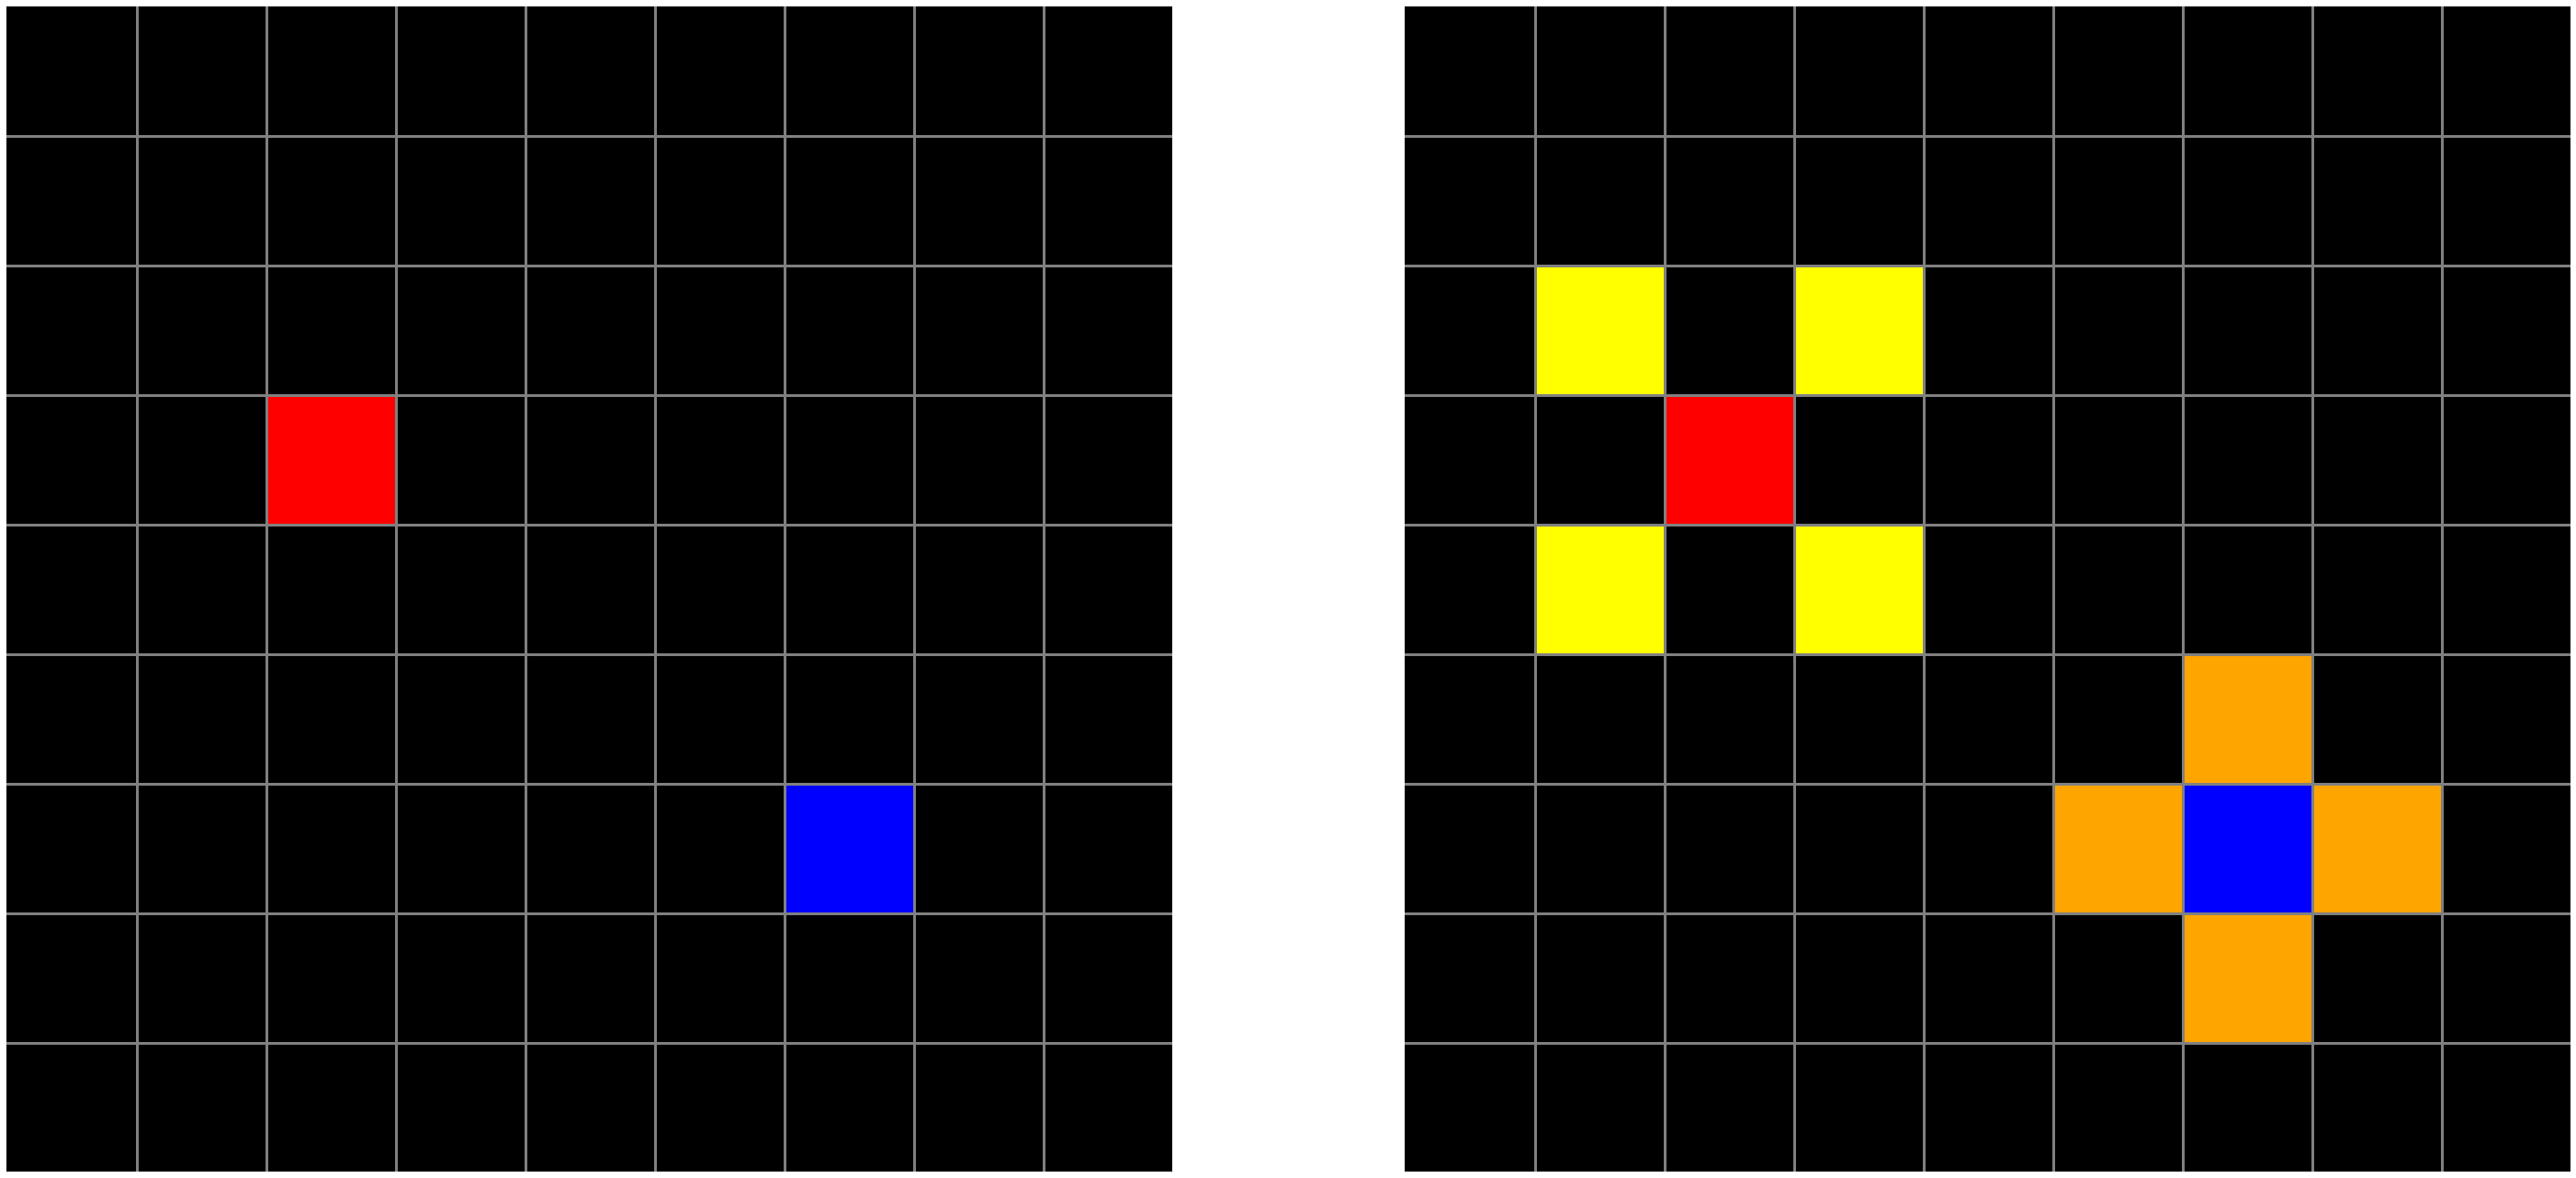

In [324]:
# evaluation, run the strategy on each square of the grid, with wrarp around, i.e., add one block of black around the whole thing
gridTrain = np.asarray(train1["train"][0]["input"])
gridTest = np.asarray(train1["train"][0]["output"])
DisplayGrids(gridTrain,gridTest)

In [345]:
def accuracy(inputGrid,outputGrid):
    acc = 0
    if inputGrid.shape != outputGrid.shape:
        return None
    for i in range(inputGrid.shape[0]):
        for j in range(inputGrid.shape[1]):
            acc += np.abs(inputGrid[i][j]-outputGrid[i][j])
    return acc

In [375]:
def viewConv(currentState,gridInput):
    image = Image.new(size=(200,200),mode='RGB',color=(255,255,255))
    draw = ImageDraw.Draw(image)
    draw.rectangle(xy=[50,100,100,150], fill=colorMap[currentState[0]])
    draw.rectangle(xy=[50,0,100,50], fill=colorMap[currentState[1]])
    draw.rectangle(xy=[0,50,50,100], fill=colorMap[currentState[2]])
    draw.rectangle(xy=[100,50,150,100], fill=colorMap[currentState[3]])
    draw.rectangle(xy=[50,50,100,100], fill=colorMap[currentState[4]])
    display(image)

In [382]:
def fitness(gridInput, gridOutput, agent):
    output = np.zeros((gridInput.shape[0],gridInput.shape[1]))
    grid = padding(gridInput)
    currentState = [0,0,0,0,0]
    for i in range(1,grid.shape[0]-1):
        for j in range(1,grid.shape[1]-1):
            # south
            currentState[0] = grid[i+1][j]
            # north
            currentState[1] = grid[i-1][j]
            # east
            currentState[2] = grid[i][j-1]
            # west
            currentState[3] = grid[i][j+1]
            # current
            currentState[4] = grid[i][j]
            viewConv(currentState,gridInput)
            index = np.where((lookupTable==currentState).all(axis=1))[0][0]
            action = agent[index]
            print(currentState,action)
            output[i-1,j-1] = action
            DisplayGrid(output)
    acc = accuracy(gridOutput,output)
    return(output,acc)

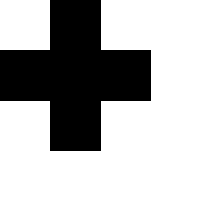

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


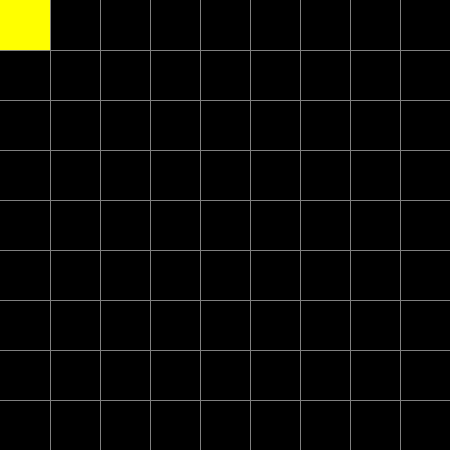

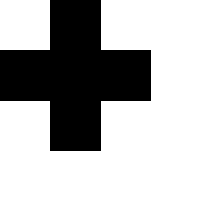

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


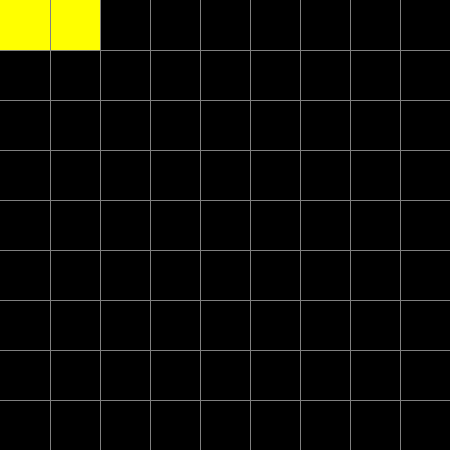

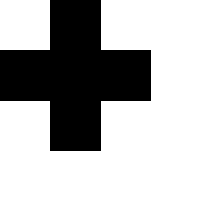

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


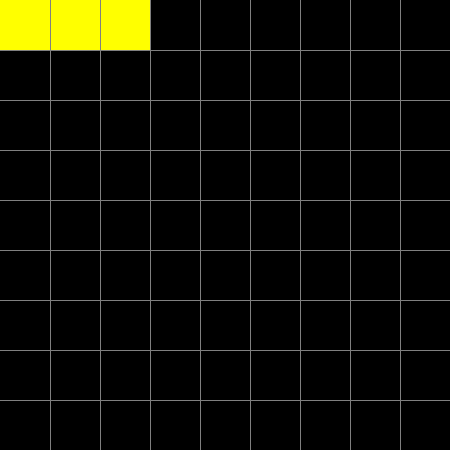

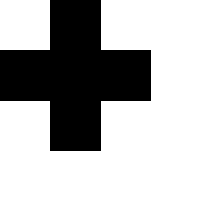

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


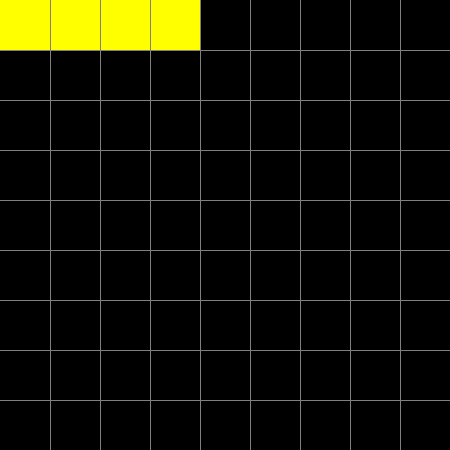

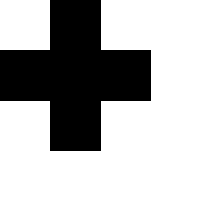

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


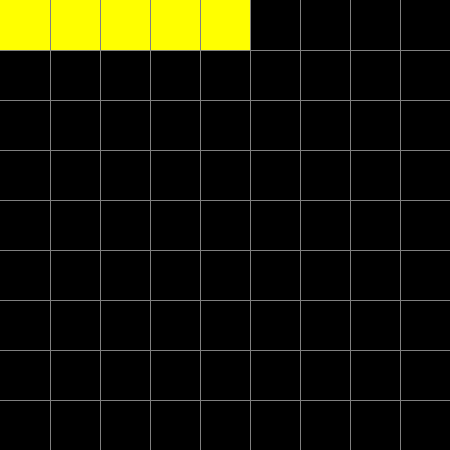

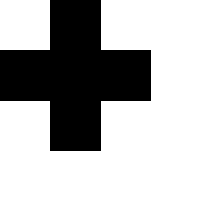

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


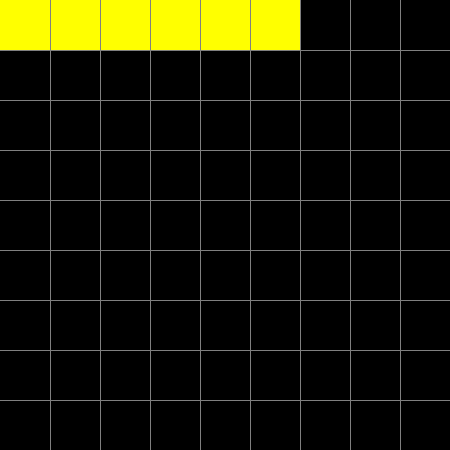

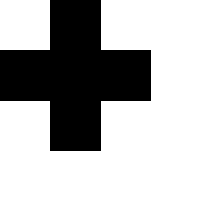

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


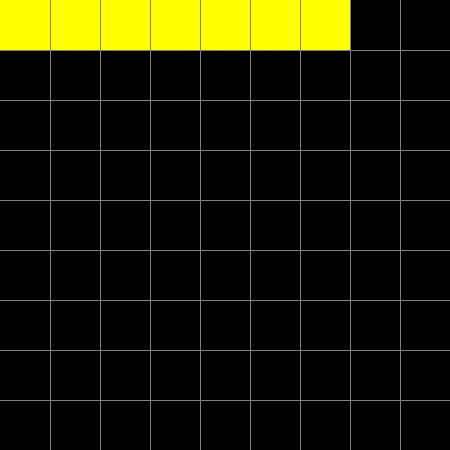

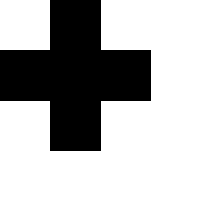

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


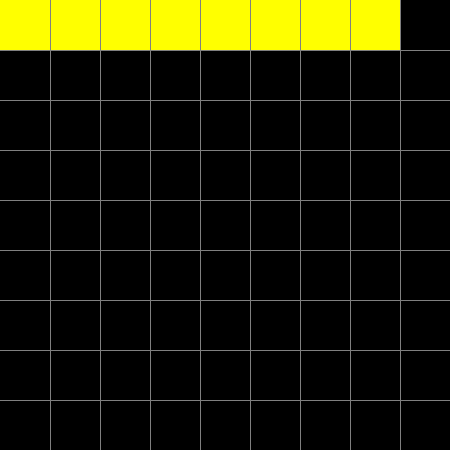

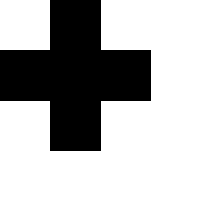

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


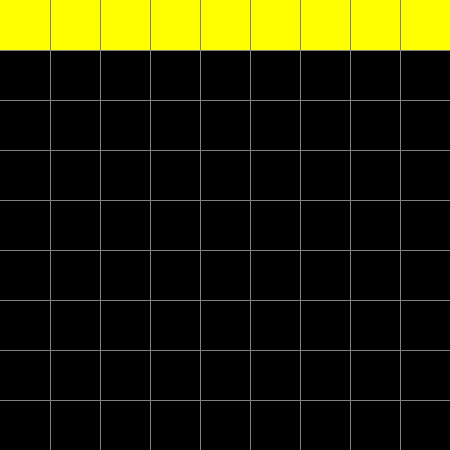

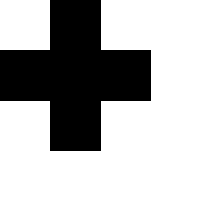

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


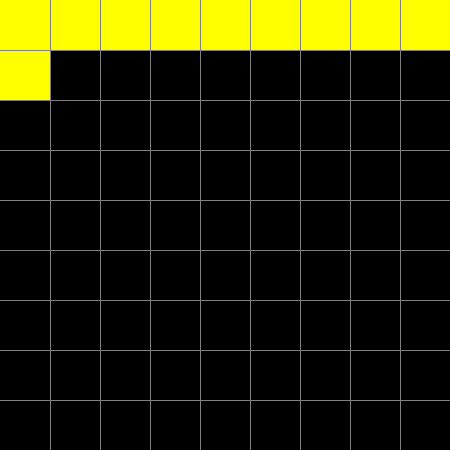

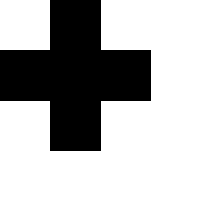

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


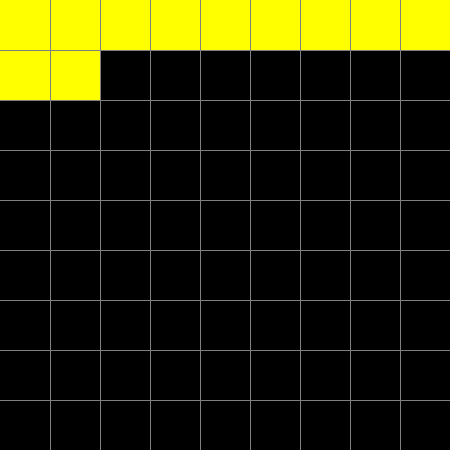

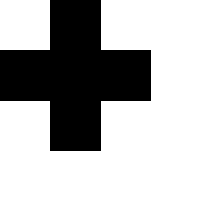

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


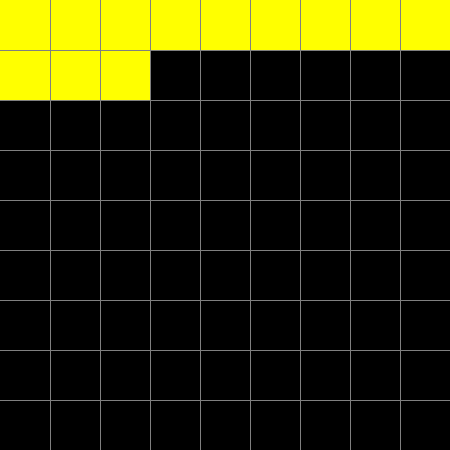

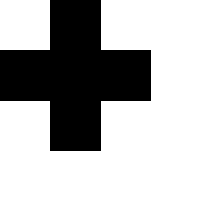

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


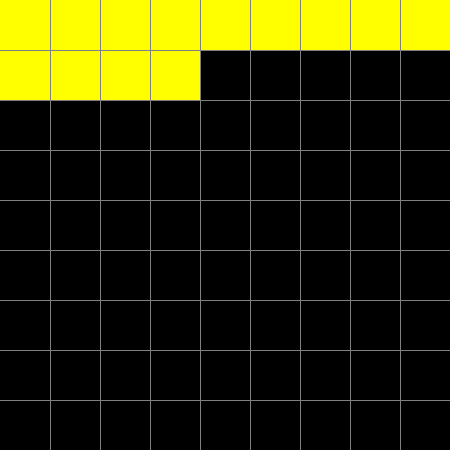

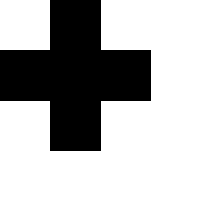

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


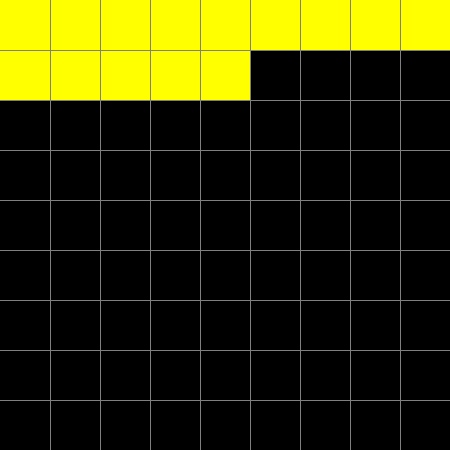

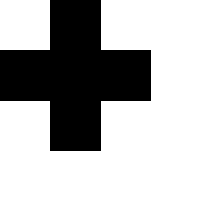

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


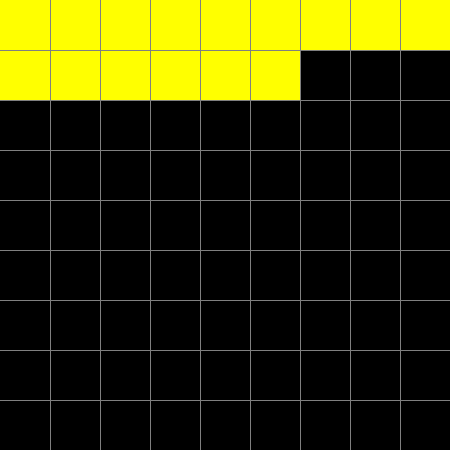

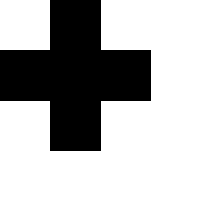

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


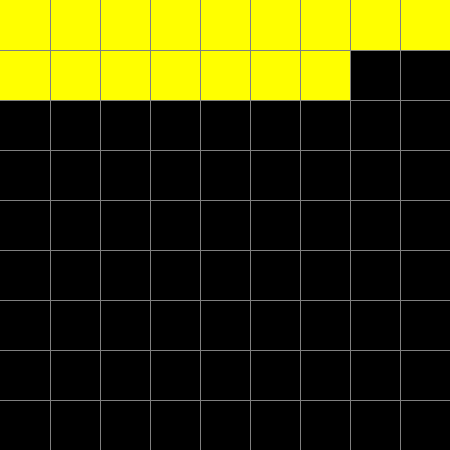

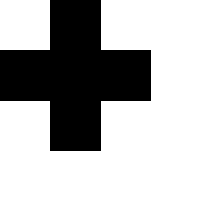

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


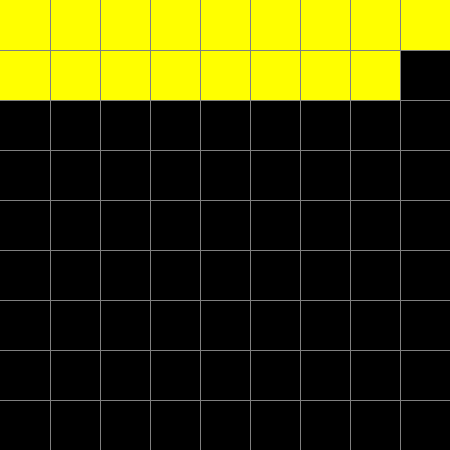

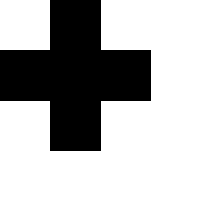

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


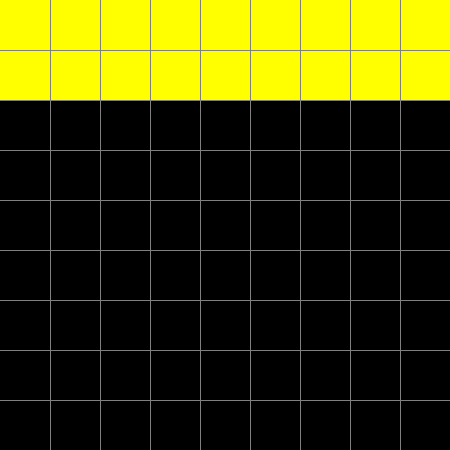

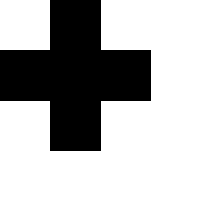

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


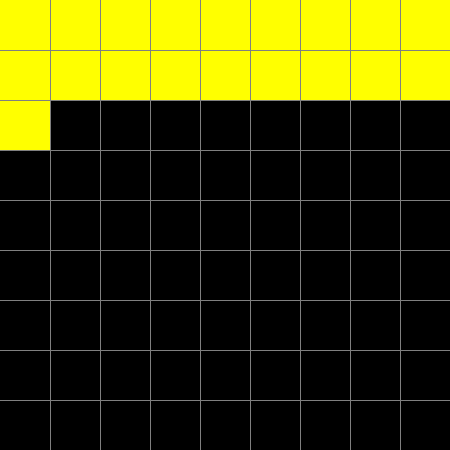

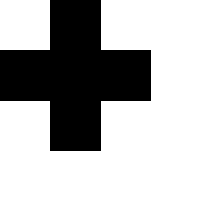

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


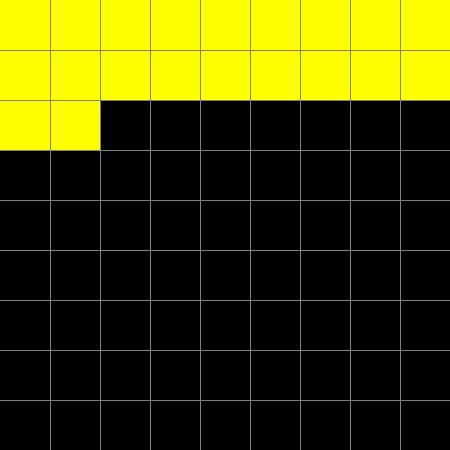

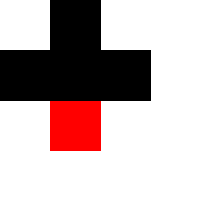

[2.0, 0.0, 0.0, 0.0, 0.0] 8.0


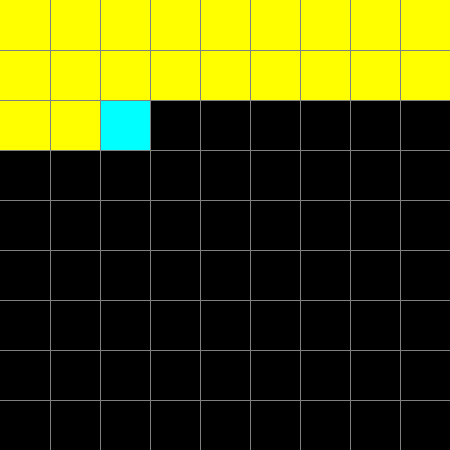

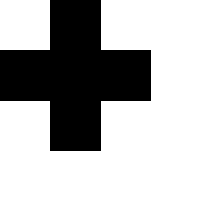

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


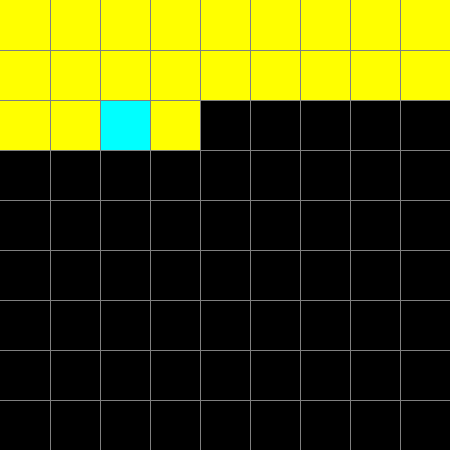

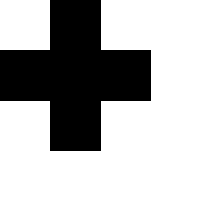

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


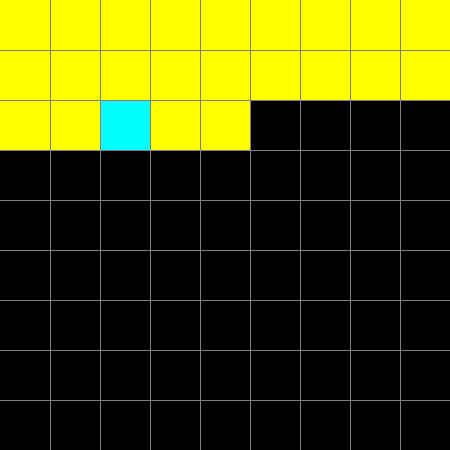

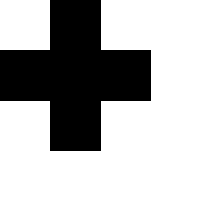

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


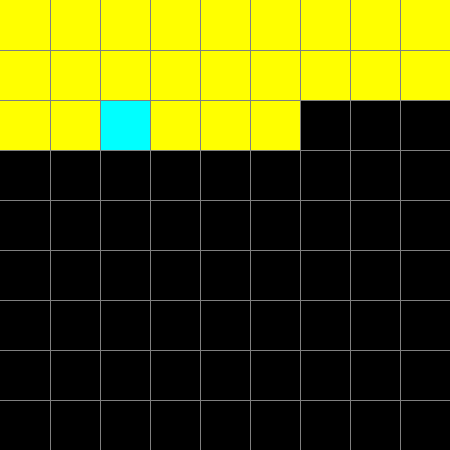

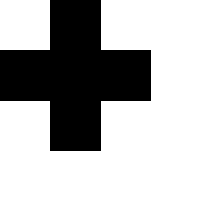

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


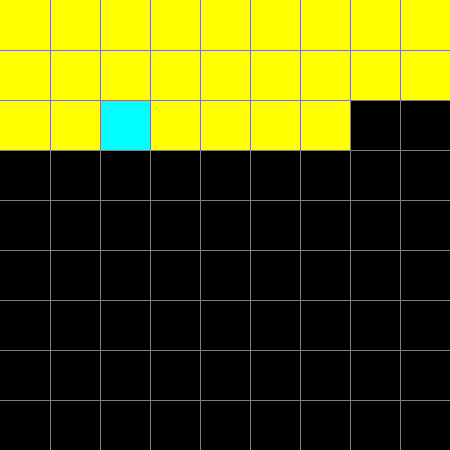

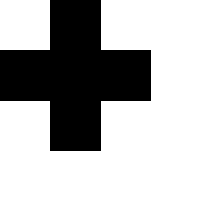

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


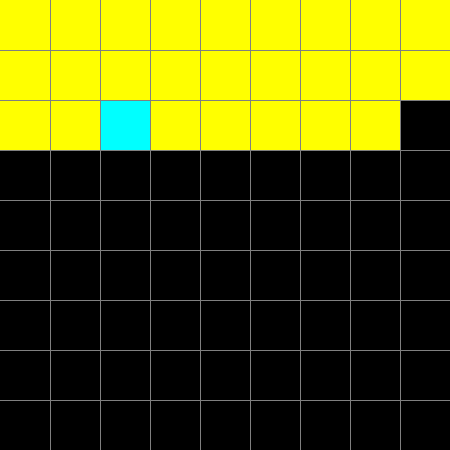

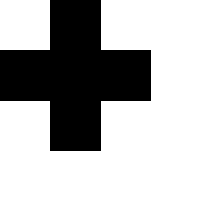

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


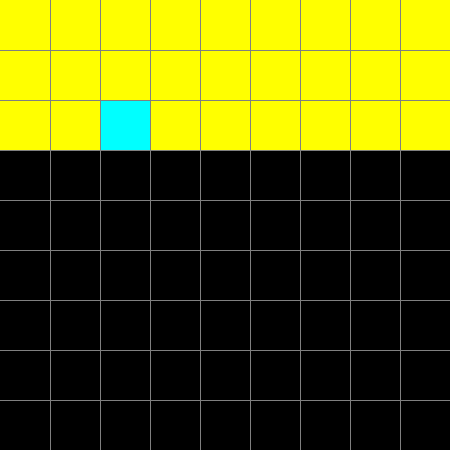

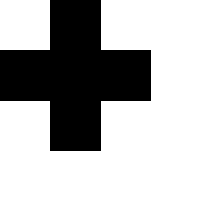

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


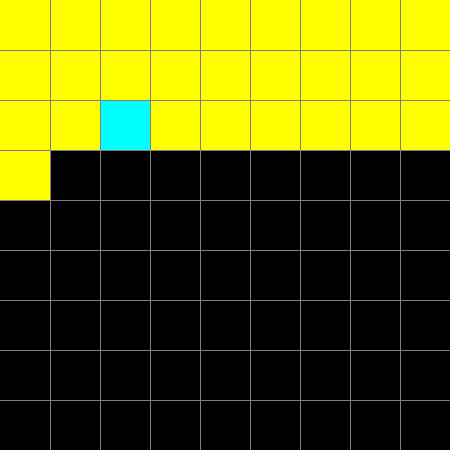

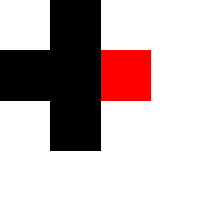

[0.0, 0.0, 0.0, 2.0, 0.0] 6.0


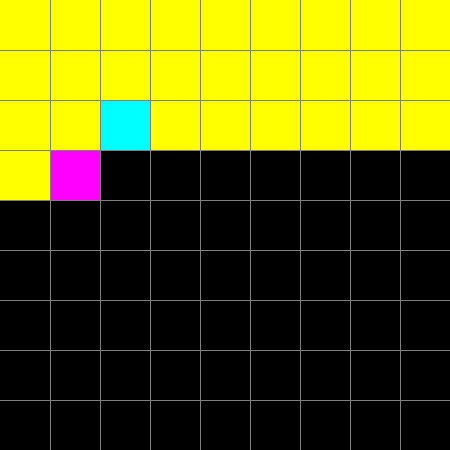

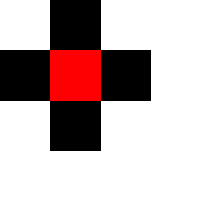

[0.0, 0.0, 0.0, 0.0, 2.0] 6.0


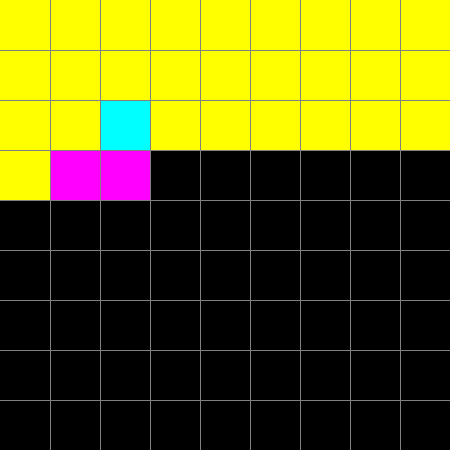

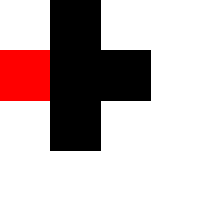

[0.0, 0.0, 2.0, 0.0, 0.0] 4.0


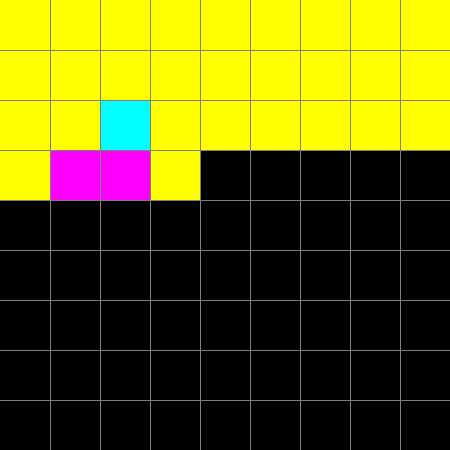

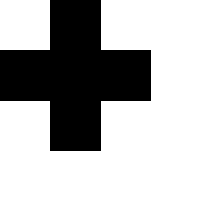

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


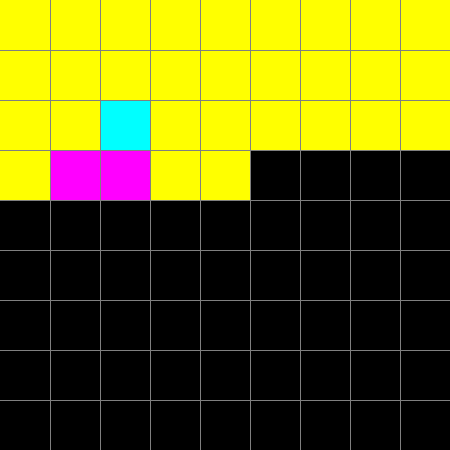

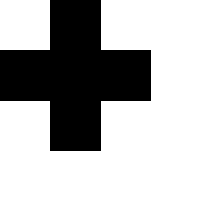

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


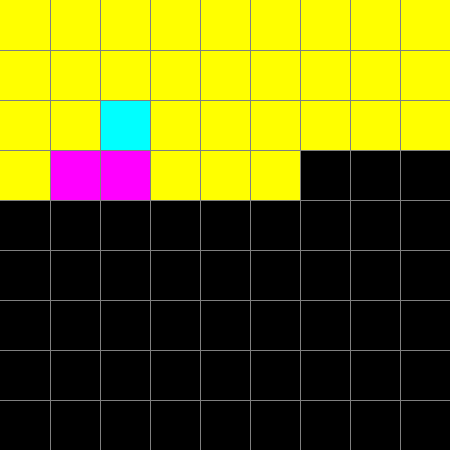

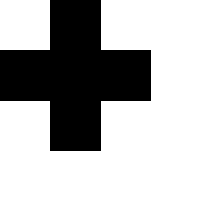

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


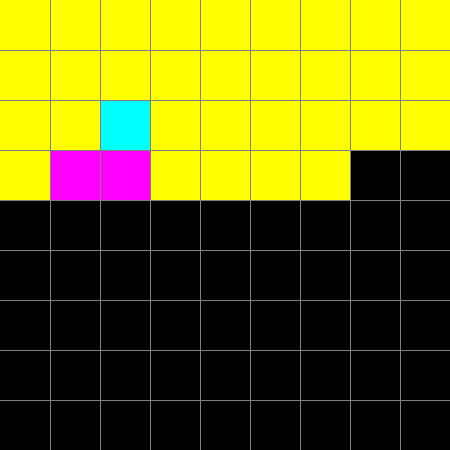

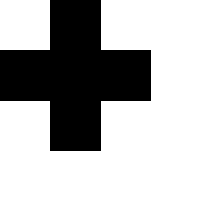

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


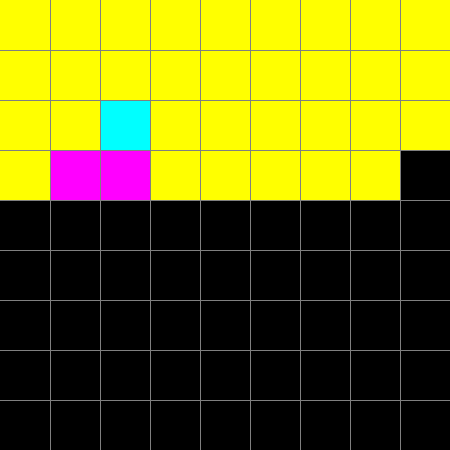

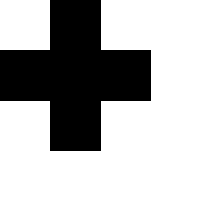

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


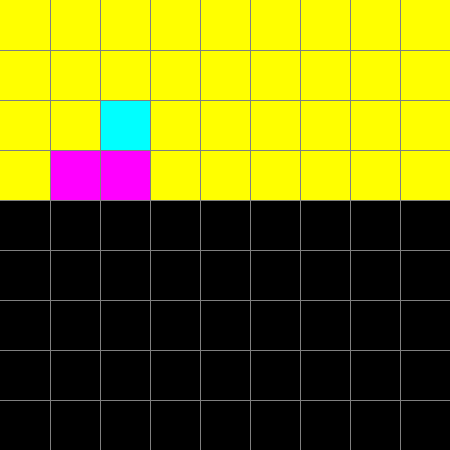

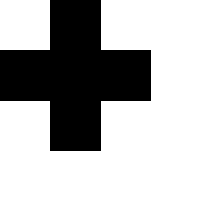

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


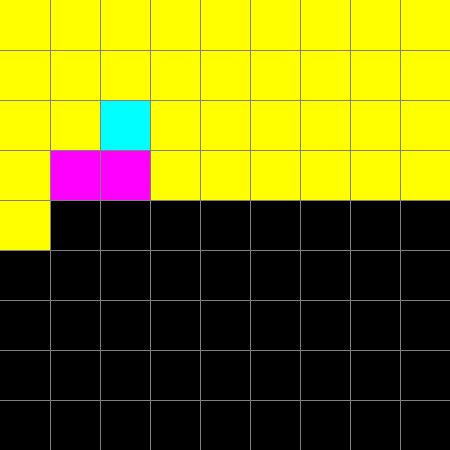

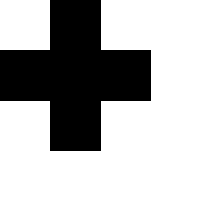

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


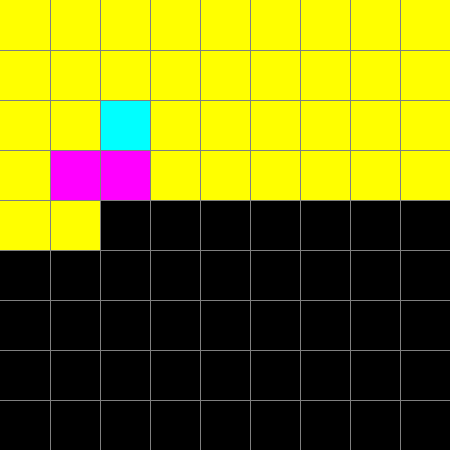

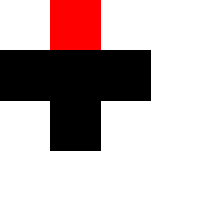

[0.0, 2.0, 0.0, 0.0, 0.0] 5.0


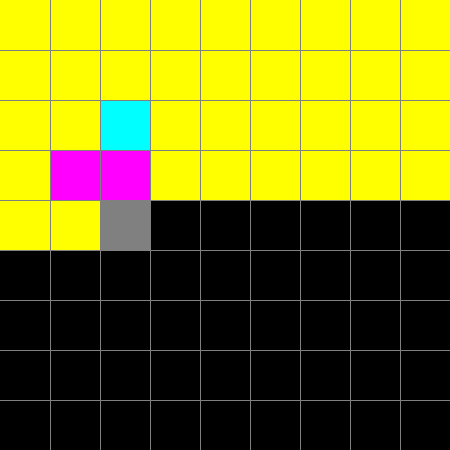

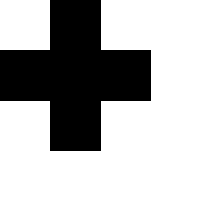

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


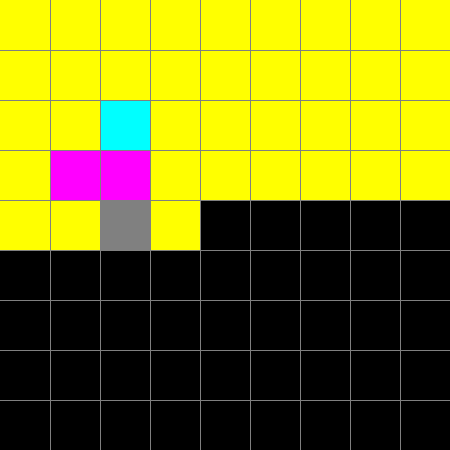

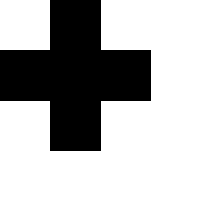

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


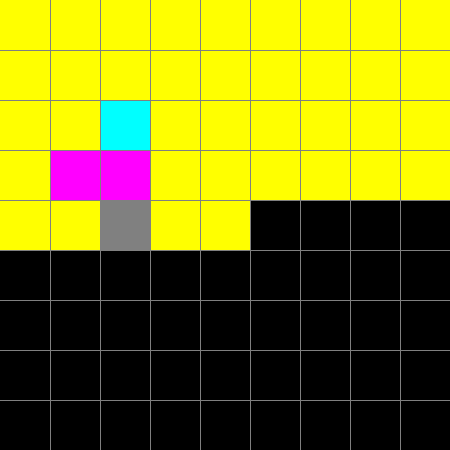

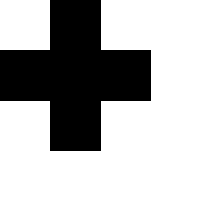

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


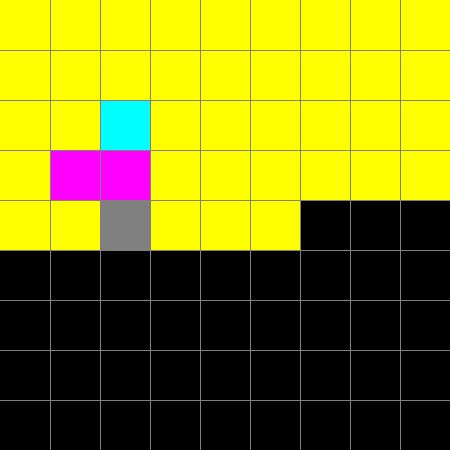

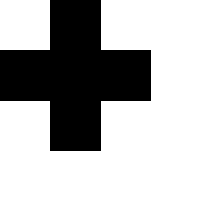

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


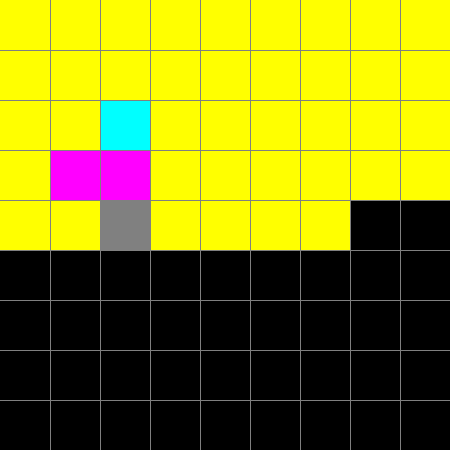

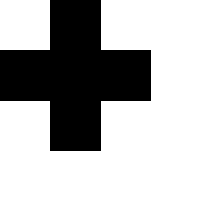

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


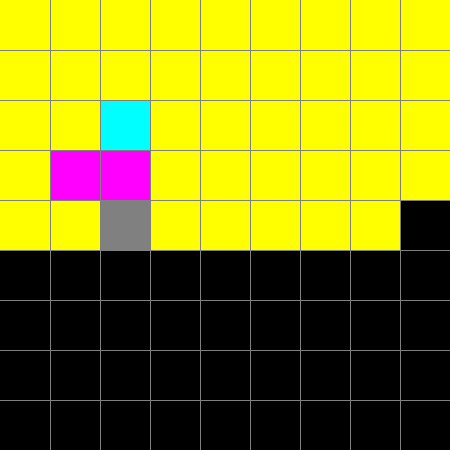

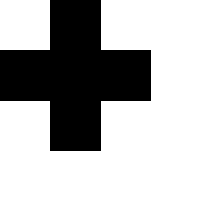

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


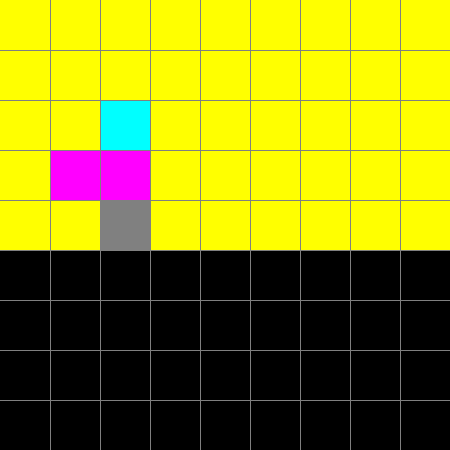

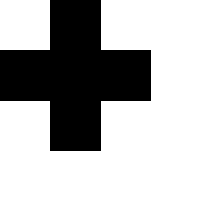

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


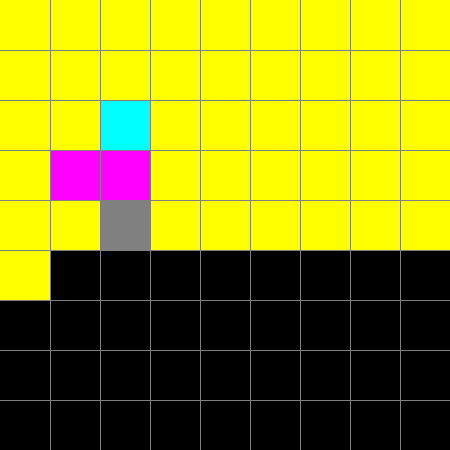

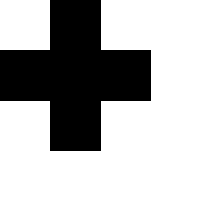

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


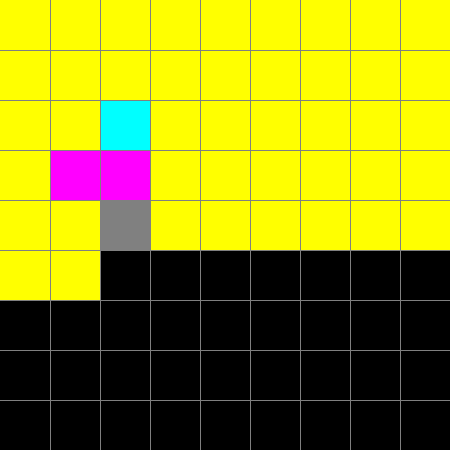

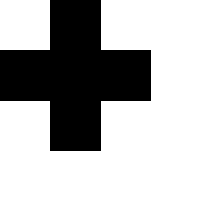

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


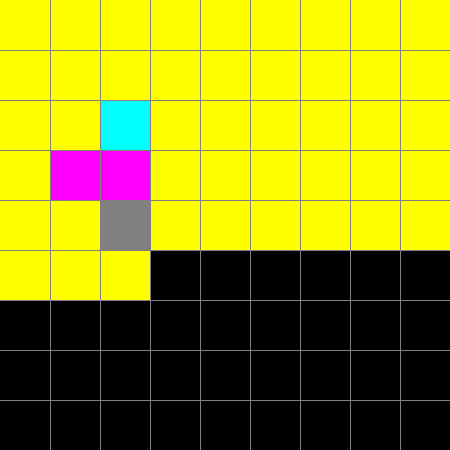

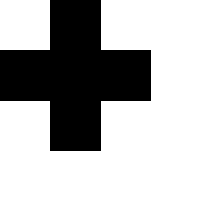

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


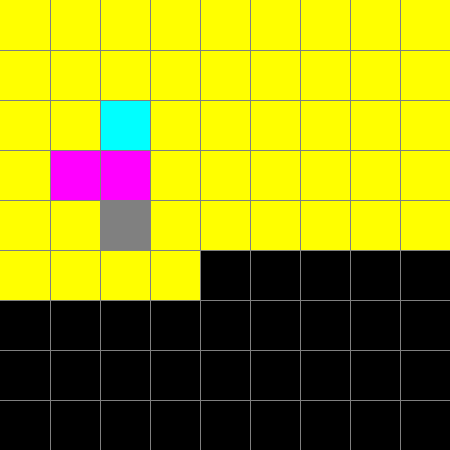

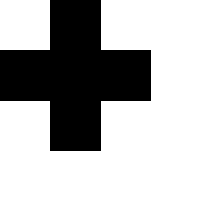

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


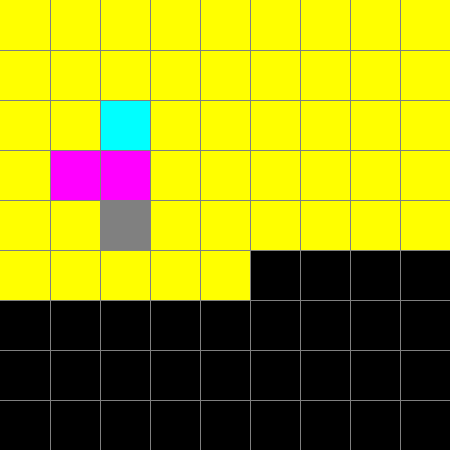

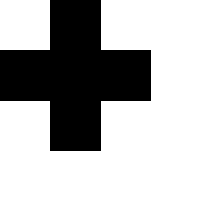

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


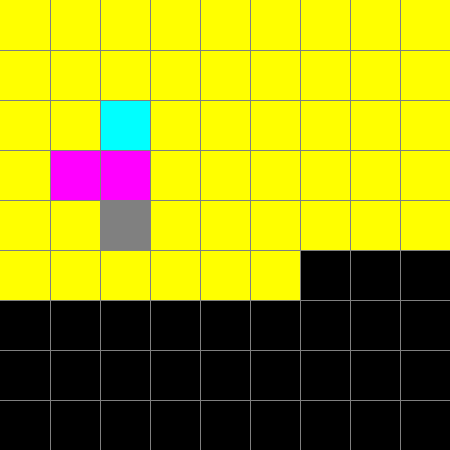

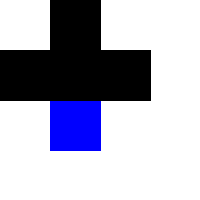

[1.0, 0.0, 0.0, 0.0, 0.0] 6.0


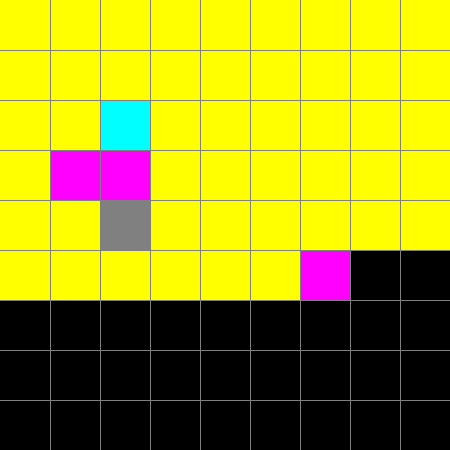

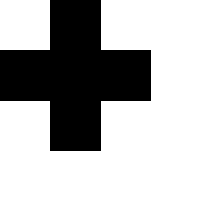

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


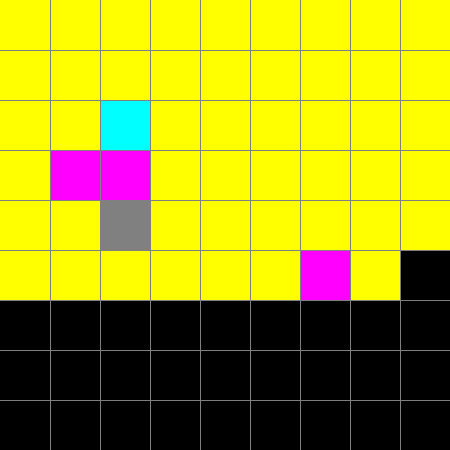

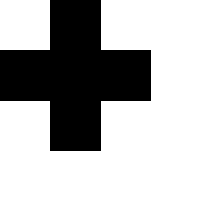

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


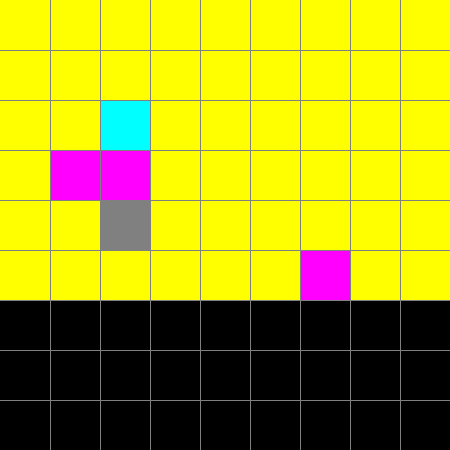

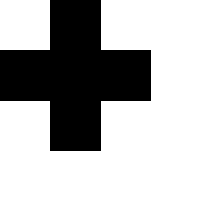

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


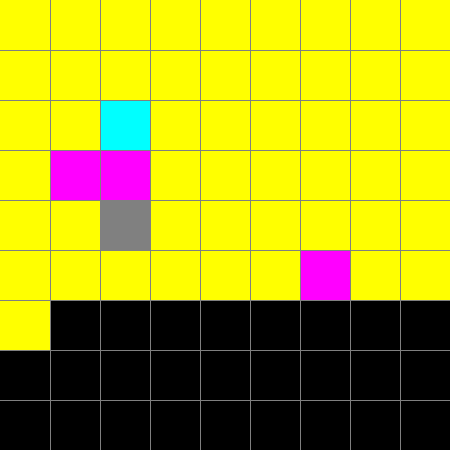

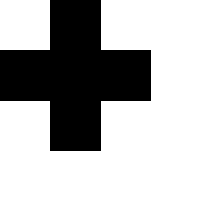

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


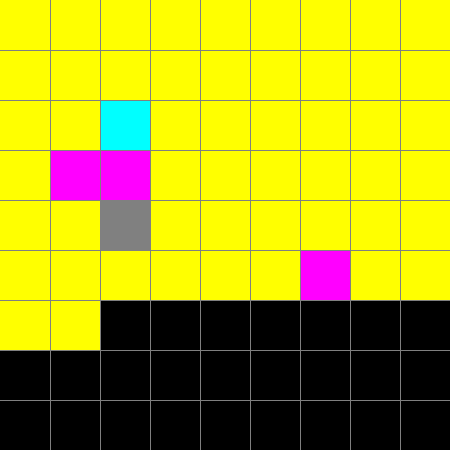

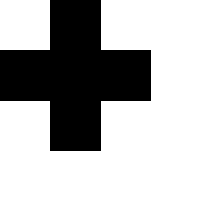

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


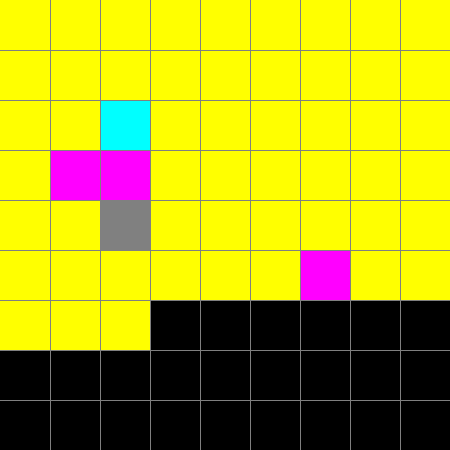

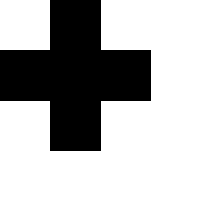

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


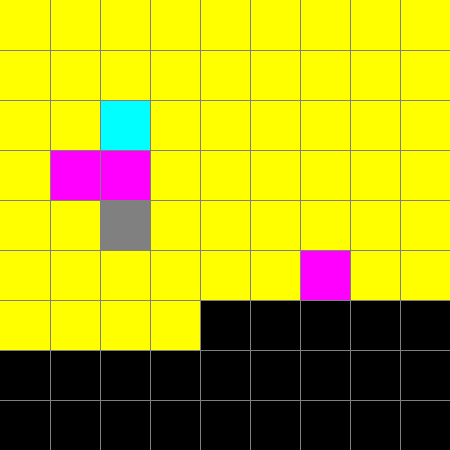

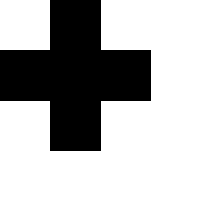

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


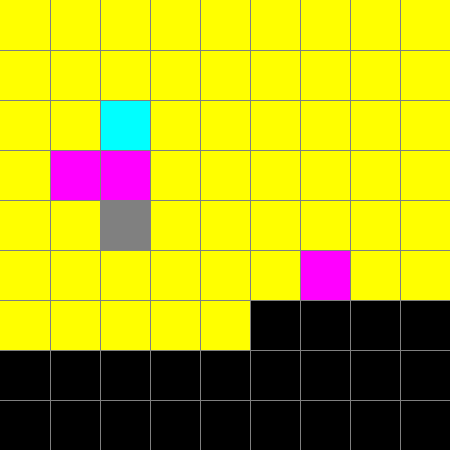

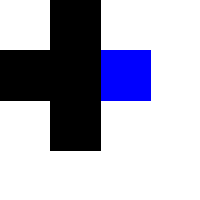

[0.0, 0.0, 0.0, 1.0, 0.0] 7.0


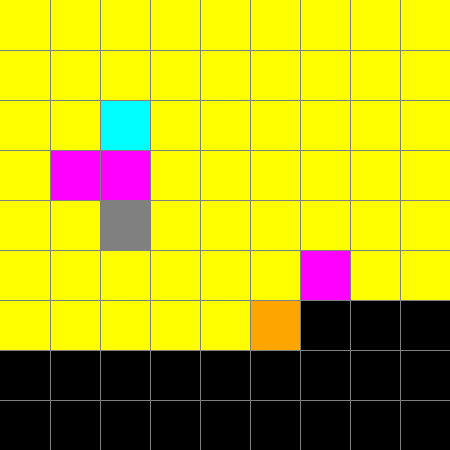

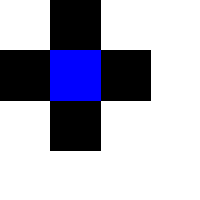

[0.0, 0.0, 0.0, 0.0, 1.0] 7.0


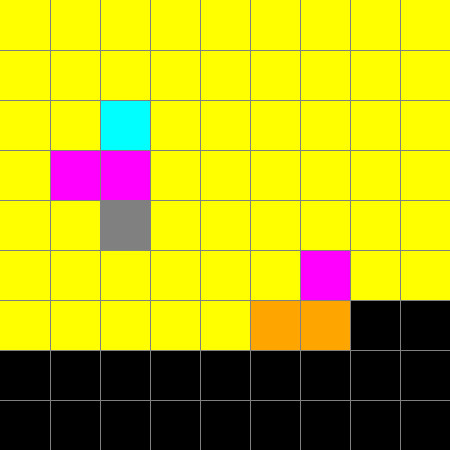

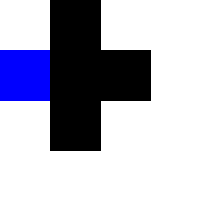

[0.0, 0.0, 1.0, 0.0, 0.0] 2.0


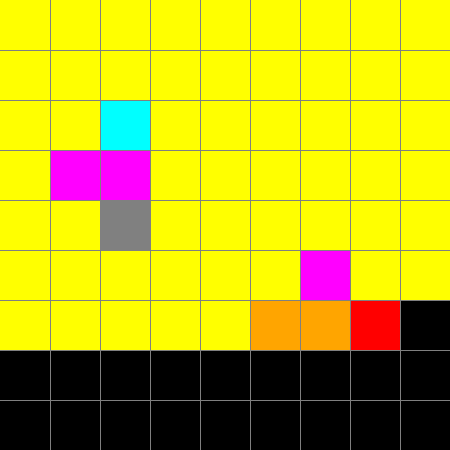

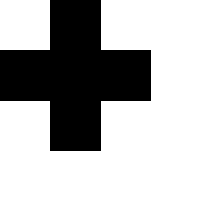

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


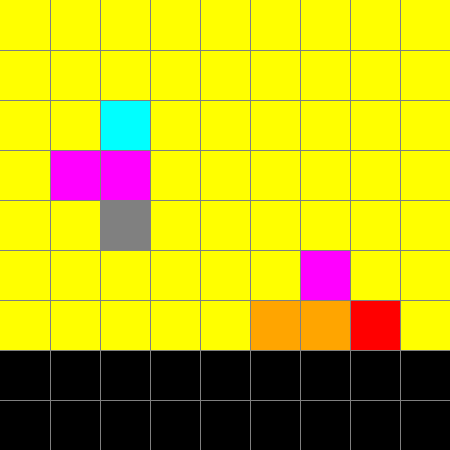

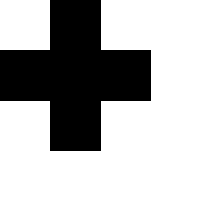

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


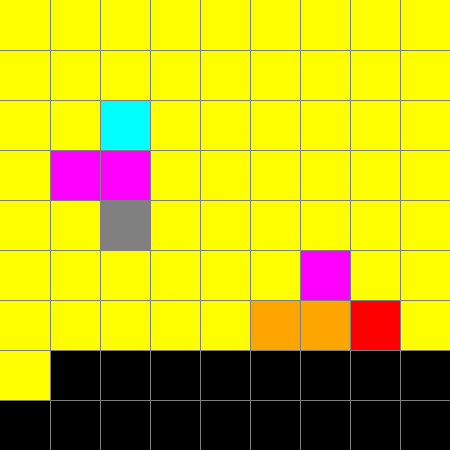

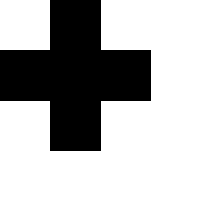

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


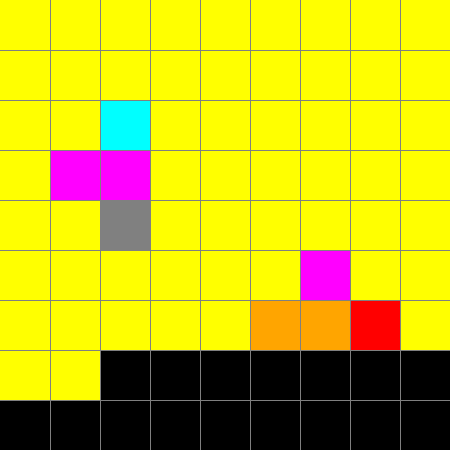

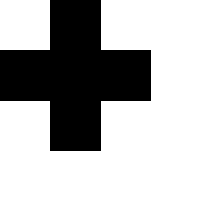

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


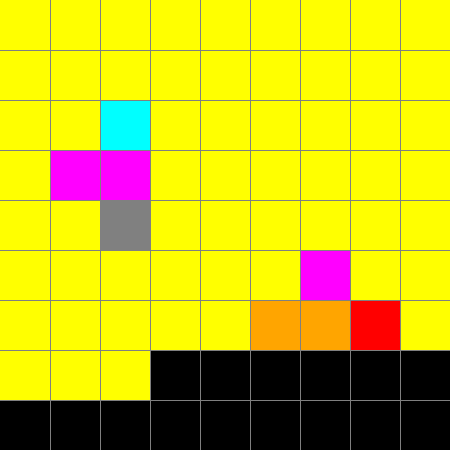

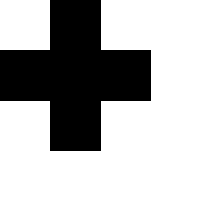

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


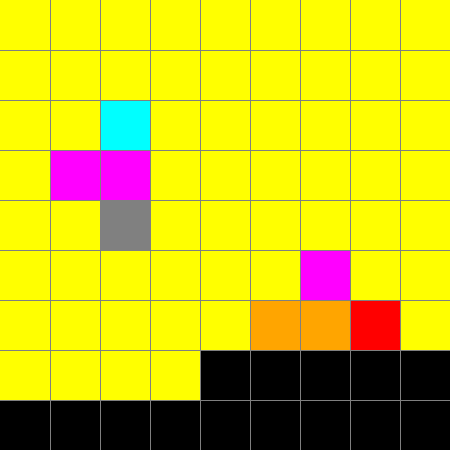

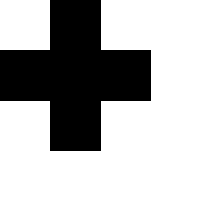

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


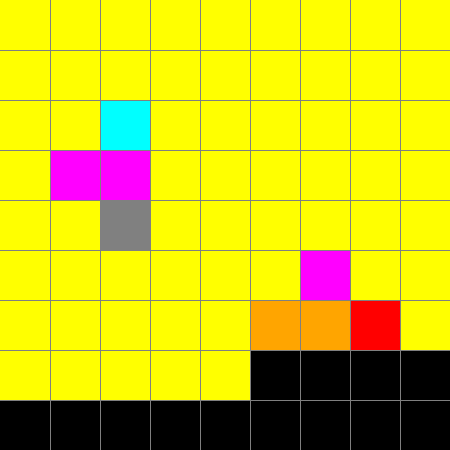

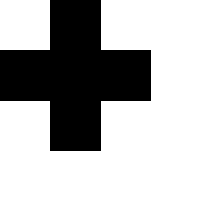

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


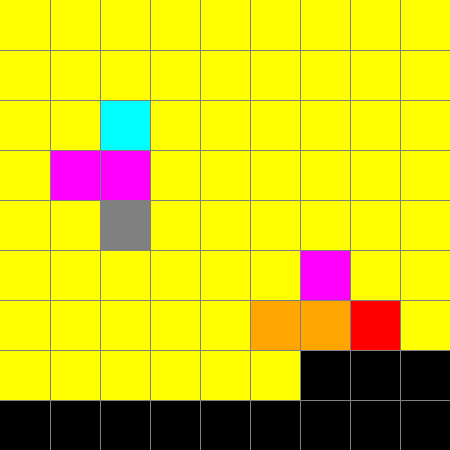

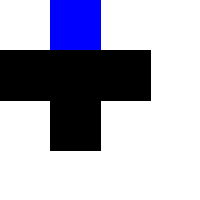

[0.0, 1.0, 0.0, 0.0, 0.0] 7.0


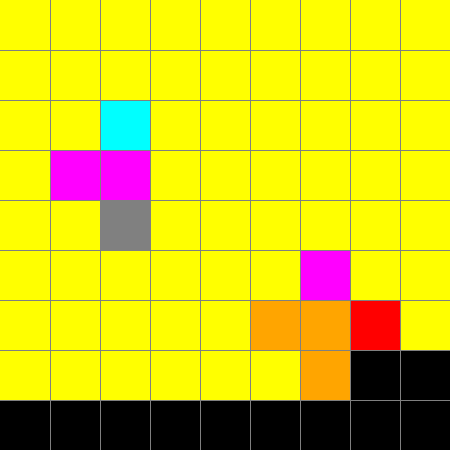

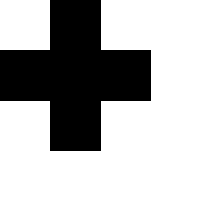

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


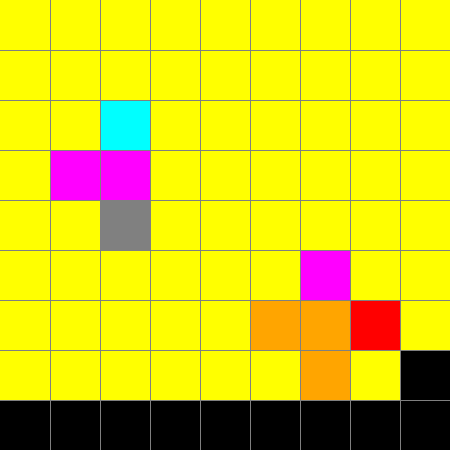

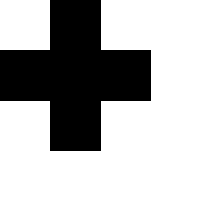

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


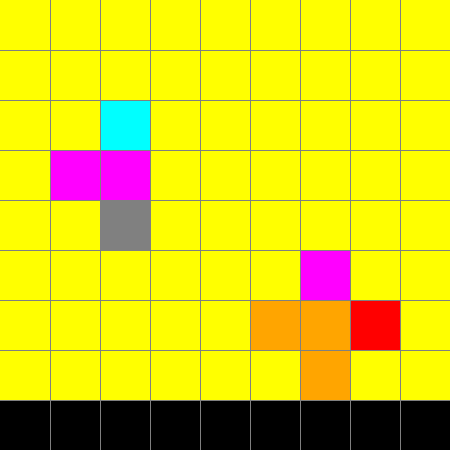

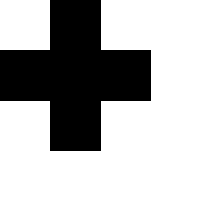

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


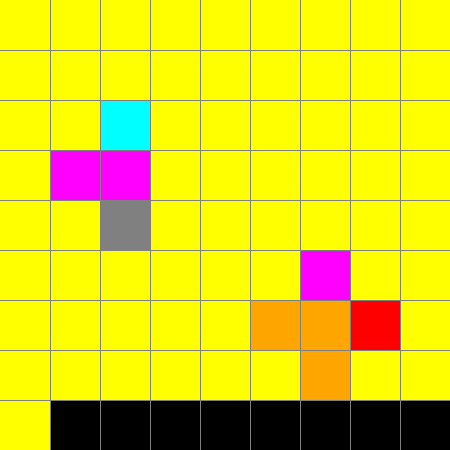

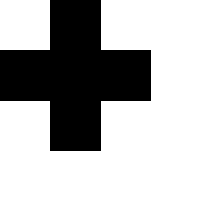

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


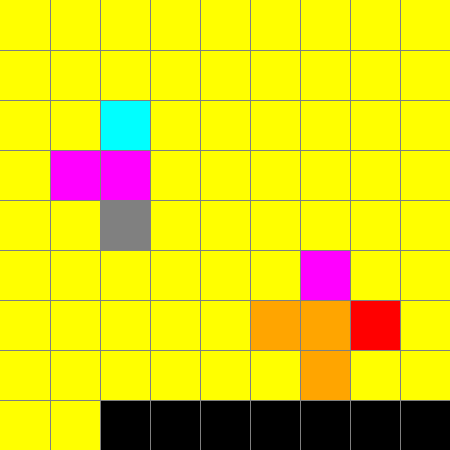

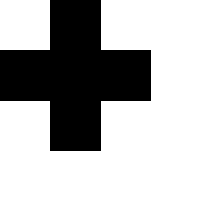

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


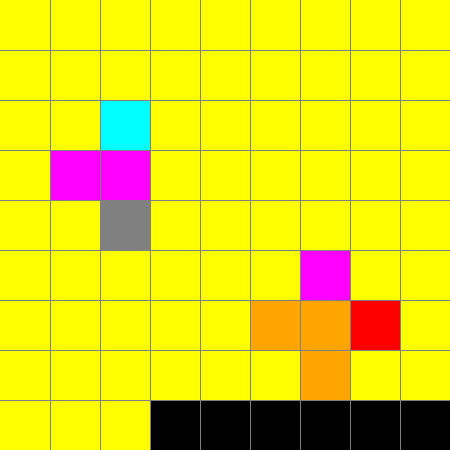

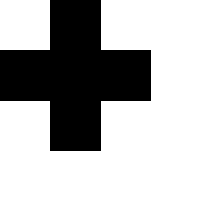

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


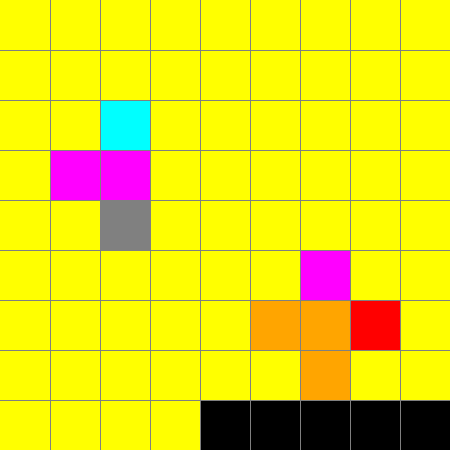

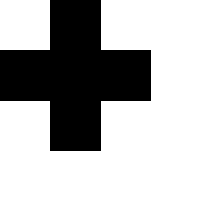

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


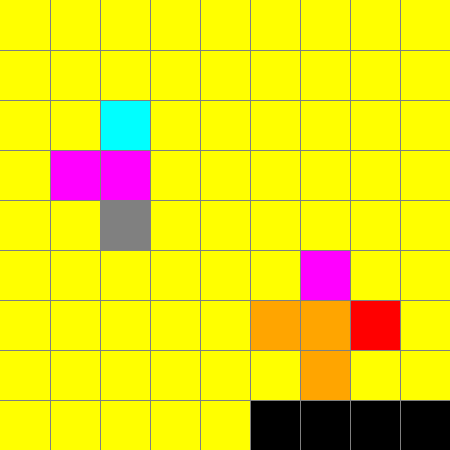

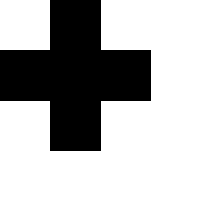

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


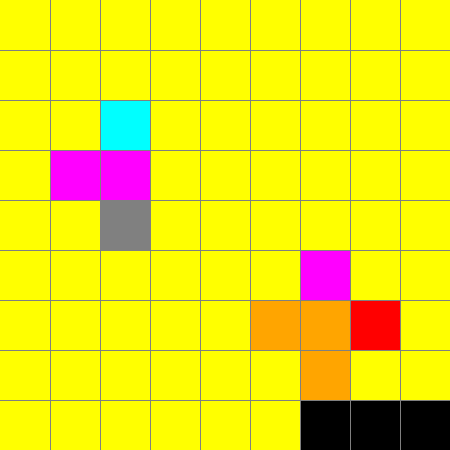

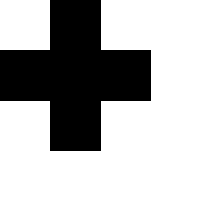

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


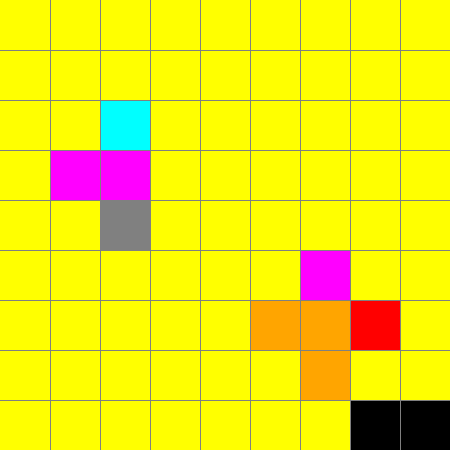

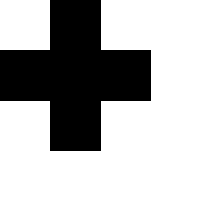

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


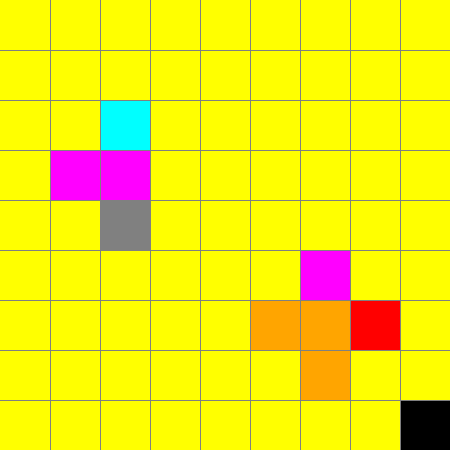

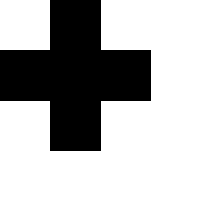

[0.0, 0.0, 0.0, 0.0, 0.0] 4.0


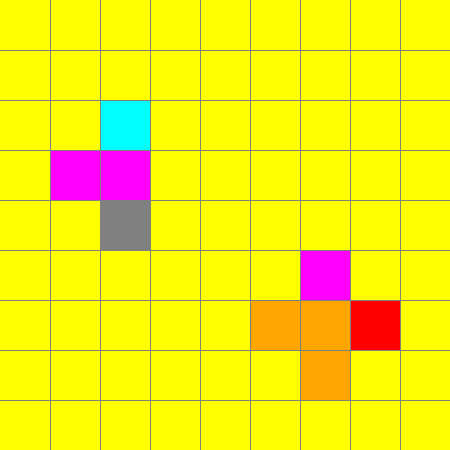

In [383]:
f = fitness(gridTrain, gridTest, agents[:,0])[0]
# DisplayGrid(f)

In [348]:
def bestFit(gridInput,gridOutput,agents):
    numAgents = len(agents[0,:])
    fit = np.zeros((200,))
    for i in range(numAgents):
        fit[i]=(fitness(gridInput,gridOutput,agents[:,i])[1])
    return(fit)

In [349]:
best = bestFit(gridTrain,gridTest,agents)

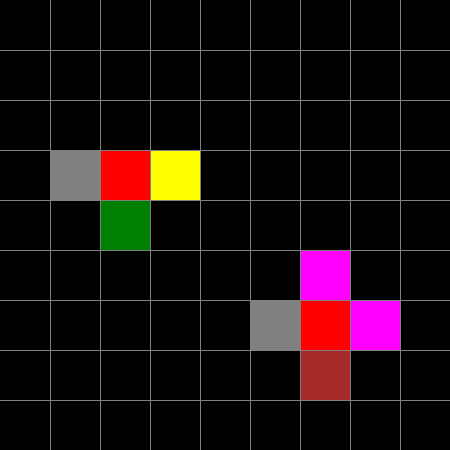

In [350]:
# Pick the best 20
topAgents = agents[:,best.argsort()[:20]]
DisplayGrid(fitness(gridTrain,gridTest,topAgents[:,0])[0])
def bestAgents(a,b,n):
    return(a[:,b.argsort()[:n]])

In [351]:
def newAgent(agent1,agent2):
    newAgent = np.zeros((100000,))
    if np.random.random() < 0.5:
        newAgent[:50000] = agent1[:50000].flatten()
        newAgent[50000:] = agent2[50000:].flatten()
    else:
        newAgent[:50000] = agent2[:50000].flatten()
        newAgent[50000:] = agent1[50000:].flatten()
    return newAgent

In [352]:
def reproduction(agents):
    numAgents = len(agents[0,:])
    newAgents = np.zeros((100000,int(numAgents/2)))
    sample = range(numAgents)
    for i in range(int(numAgents/2)):
        agent1 = topAgents[:,np.random.choice(sample,1,replace=False)]
        agent2 = topAgents[:,np.random.choice(sample,1,replace=False)]
        new = newAgent(agent1,agent2)
        newAgents[:,i] = new
    return newAgents

In [353]:
evo = reproduction(topAgents)
print(len(evo[0,:]))

10


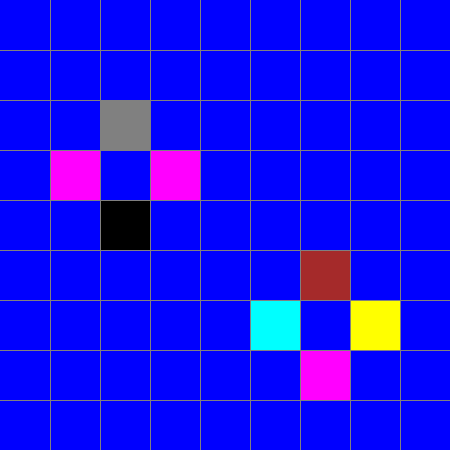

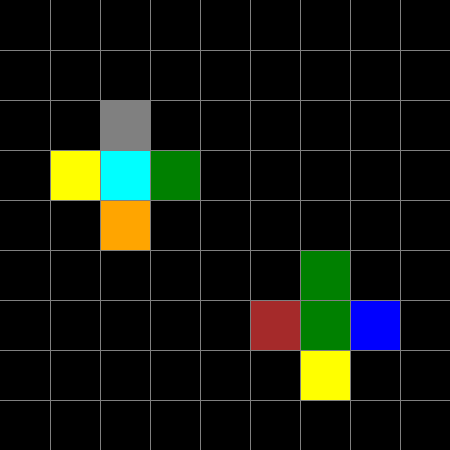

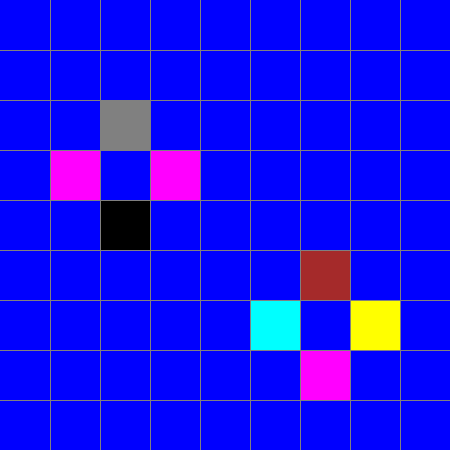

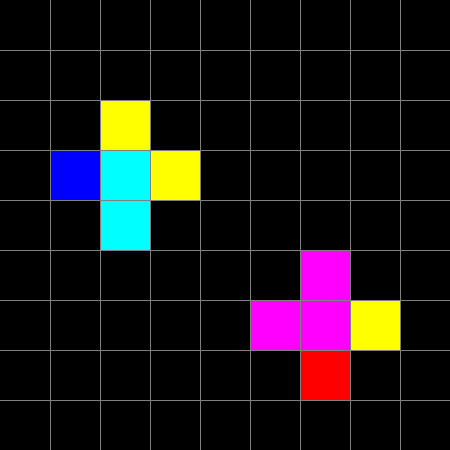

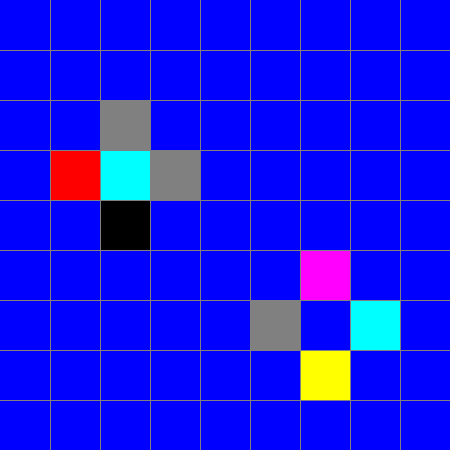

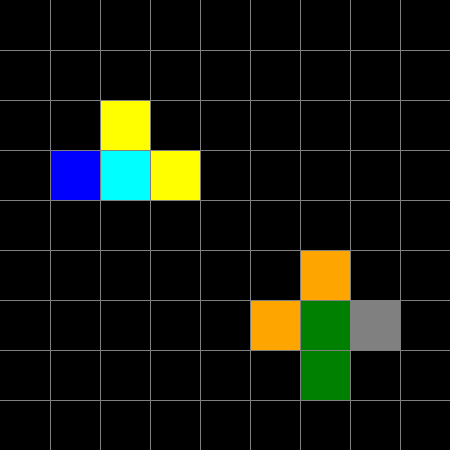

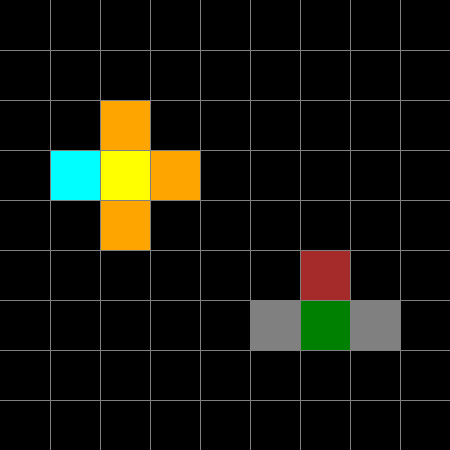

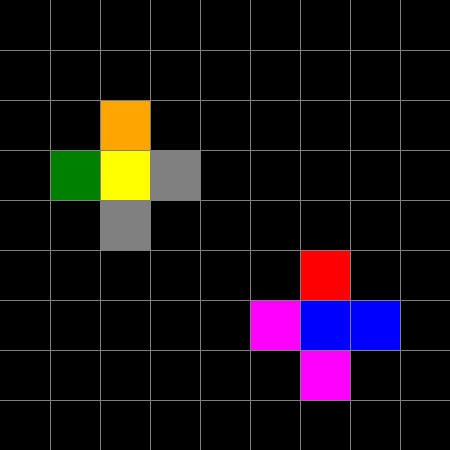

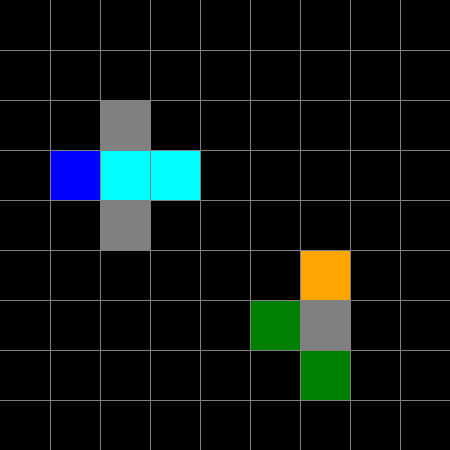

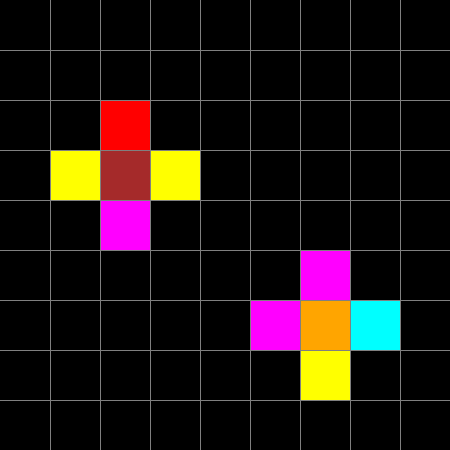

In [354]:
for i in range(len(evo[0,:])):
    DisplayGrid(fitness(gridTrain,gridTest,evo[:,i])[0])

In [355]:
# spawn 10 more mutations for each for a total of 200 and add 100 hundred random ones into the mix

In [356]:
def mutation(agent):
    c = 0
    for i in range(len(agent)):
        if np.random.random() < 0.005:
            c+=1
            agent[i] = np.random.choice(range(10),1,replace=True)
    return agent

In [357]:
def nextAgents(topAgents):
    agents = np.zeros((100000,200))
    for i in range(10):
        for j in range(10):
            agents[:,i] = mutation(topAgents[:,i])
    for i in range(100,200):
        agents[:,i] = np.random.randint(0,10,100000)
    return agents

In [358]:
newBatch = nextAgents(evo)
print(newBatch)

[[1. 0. 1. ... 5. 8. 4.]
 [1. 3. 1. ... 2. 4. 3.]
 [1. 8. 2. ... 0. 5. 9.]
 ...
 [0. 9. 3. ... 7. 8. 2.]
 [2. 6. 7. ... 1. 9. 3.]
 [4. 9. 1. ... 8. 2. 9.]]


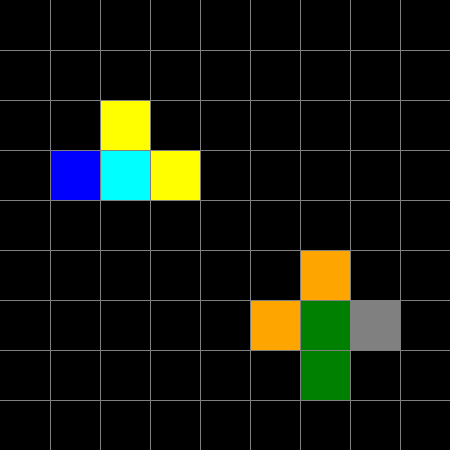

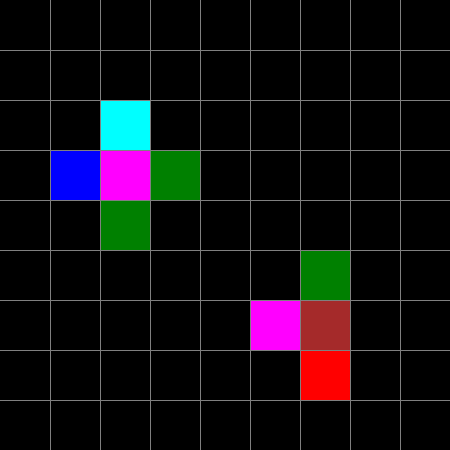

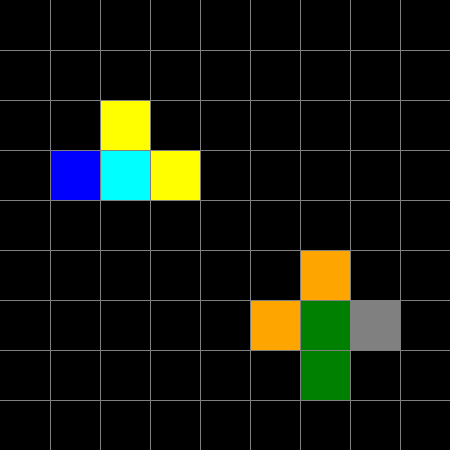

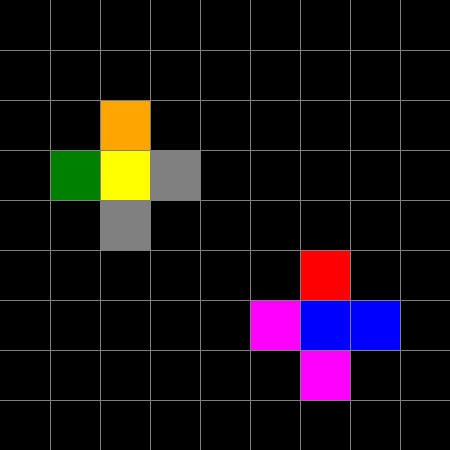

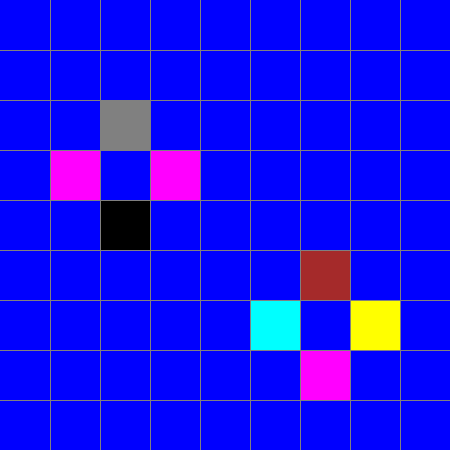

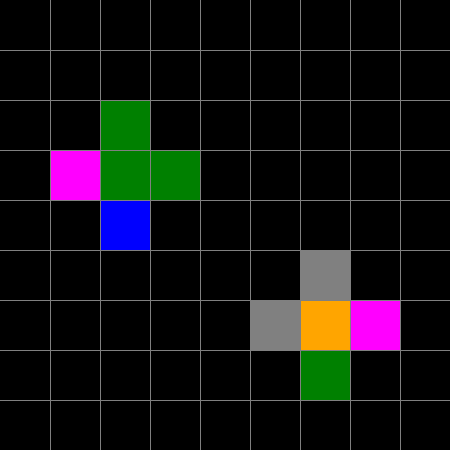

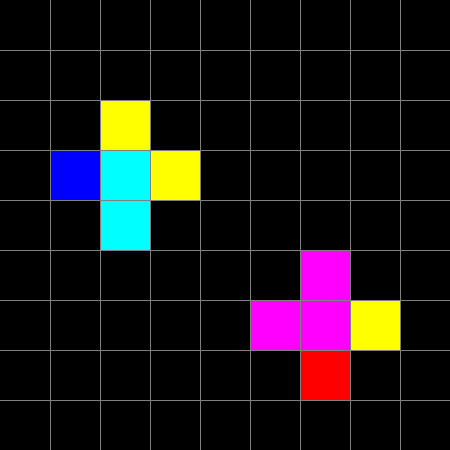

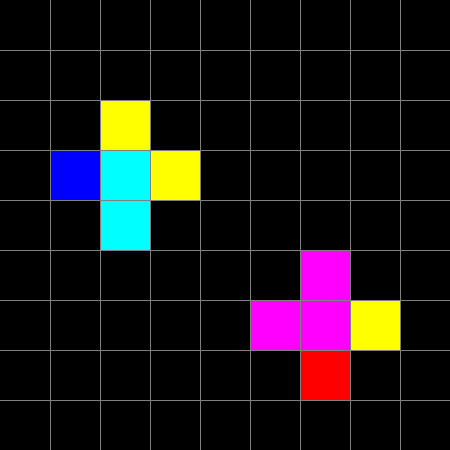

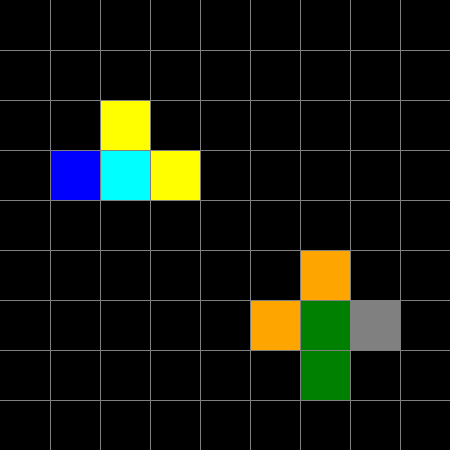

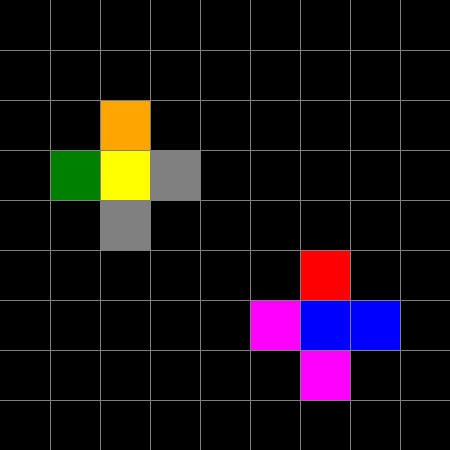

In [359]:
# second through n run
bFit = bestFit(gridTrain,gridTest,newBatch)
bAgents = bestAgents(newBatch,bFit,20)
evo = reproduction(bAgents)
for i in range(len(evo[0,:])):
    DisplayGrid(fitness(gridTrain,gridTest,evo[:,i])[0])
newBatch = nextAgents(evo)

In [360]:
def evolution(gridInput,gridOutput,agents):
    bFit = bestFit(gridInput,gridOutput,agents)
    bAgents = bestAgents(newBatch,bFit,20)
    evo = reproduction(bAgents)
    for i in range(len(evo[0,:])):
        DisplayGrid(fitness(gridInput,gridOutput,evo[:,i])[0])
    newBatch = nextAgents(evo)
    return(newBatch)

In [361]:
def evolutionRecursive(gridInput,gridOutput,bAgents,n):
    if n==1:
        return bAgents
    else:
        bFit = bestFit(gridInput,gridOutput,bAgents)
        bAgents = bestAgents(bAgents,bFit,20)
        evo = reproduction(bAgents)
        for i in range(len(evo[0,:])):
            DisplayGrid(fitness(gridInput,gridOutput,evo[:,i])[0])
        newBatch = nextAgents(evo)
        evolutionRecursive(gridInput,gridOutput,newBatch,n-1)

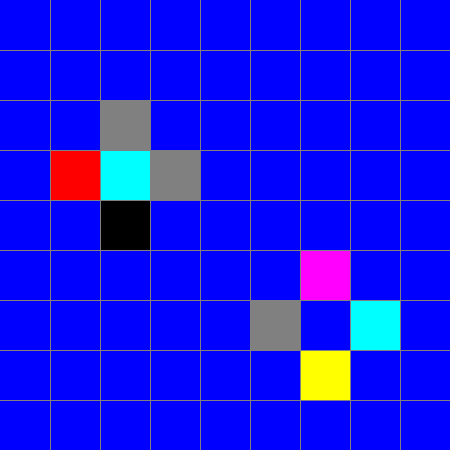

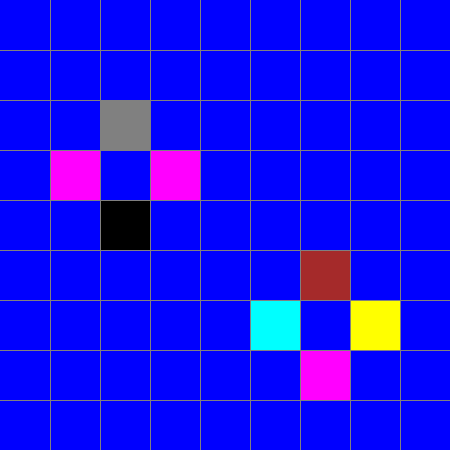

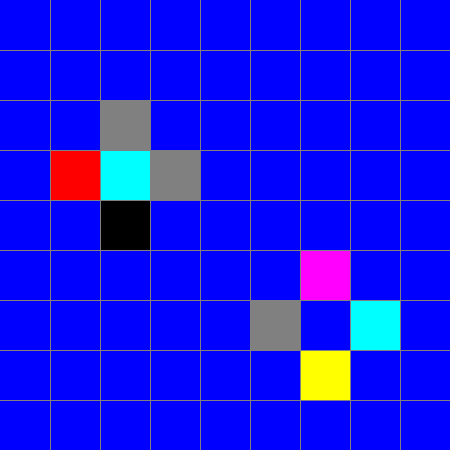

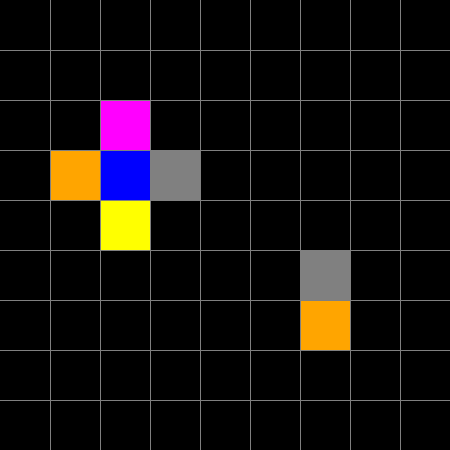

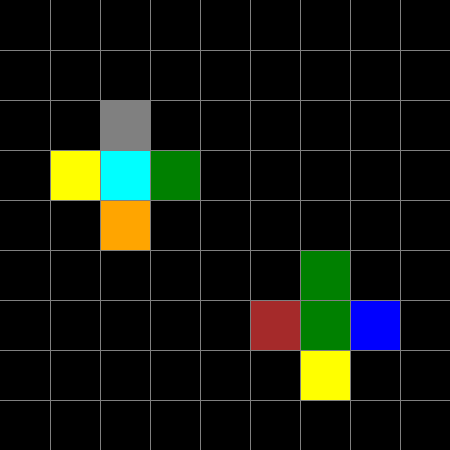

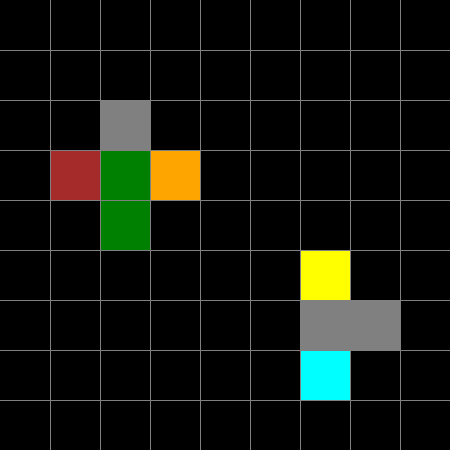

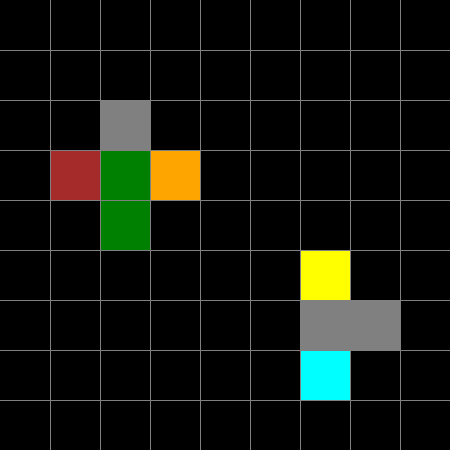

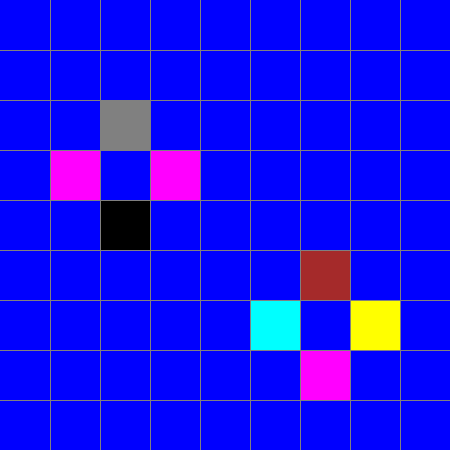

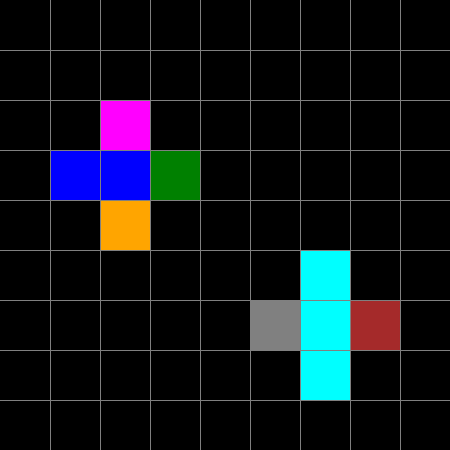

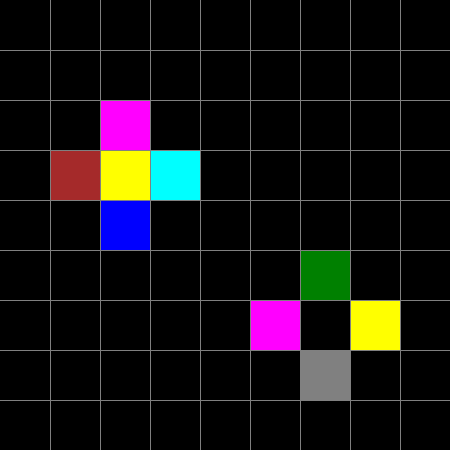

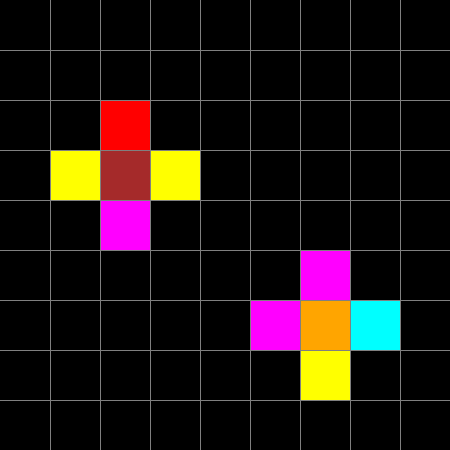

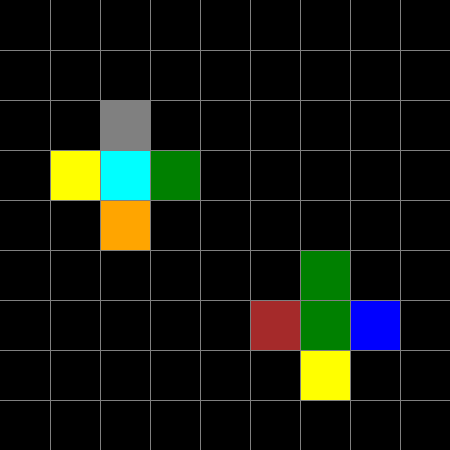

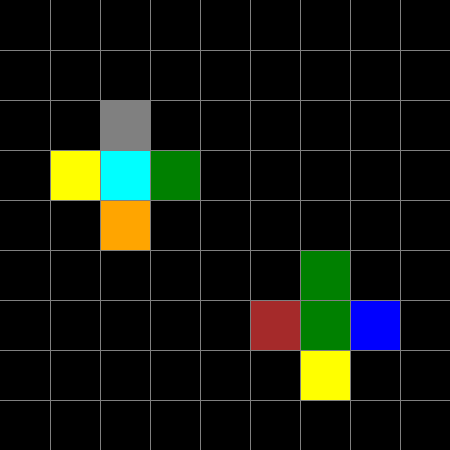

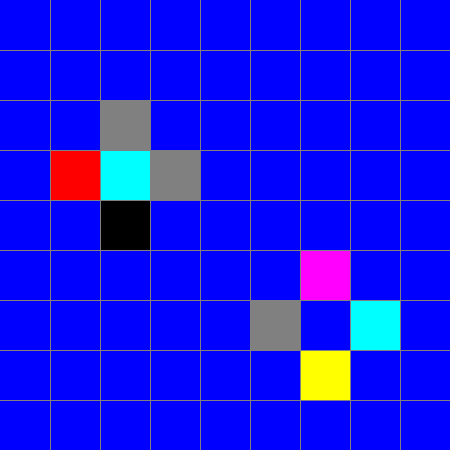

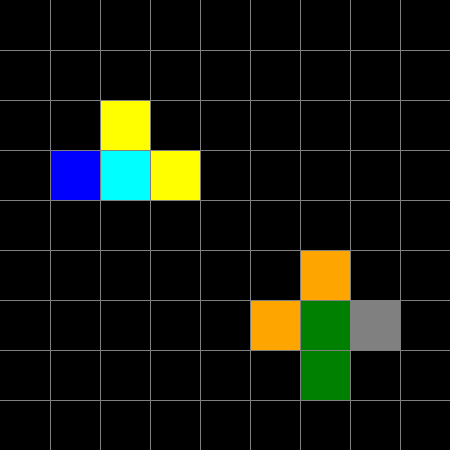

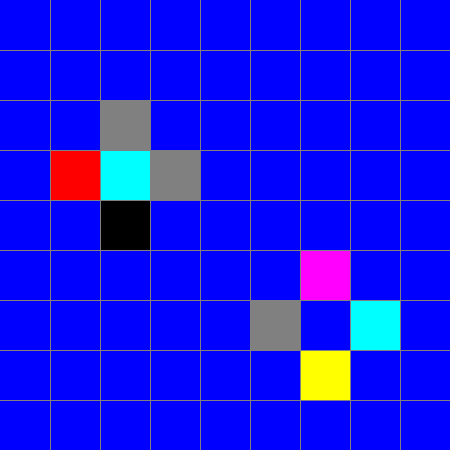

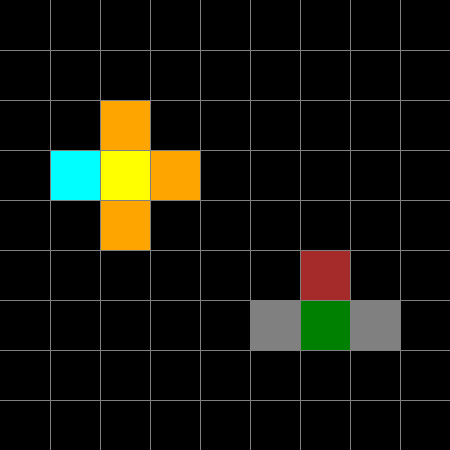

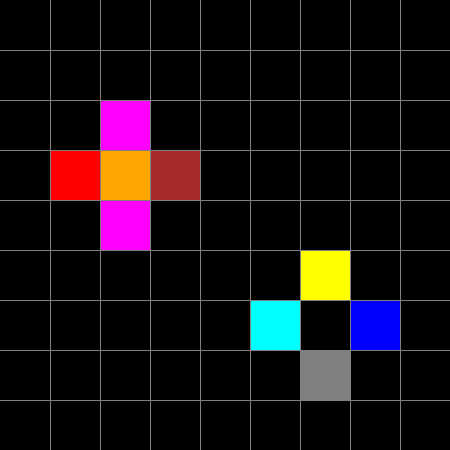

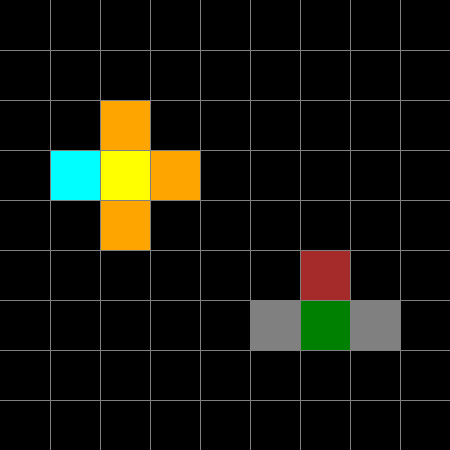

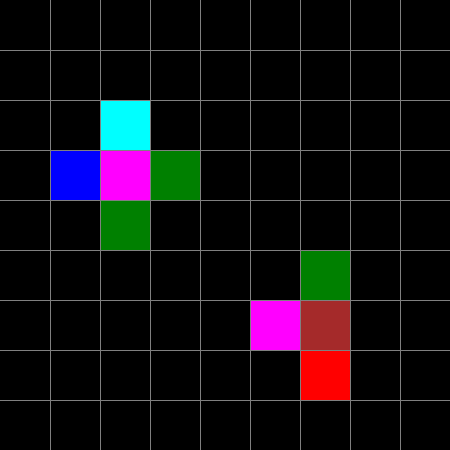

In [362]:
evolutionRecursive(gridTrain,gridTest,newBatch,3)